# שלב 4 – מודלים מתקדמים (CTM ו‑Contextual‑Top2Vec) על דאטה עברי

מחברת זו מניחה שהרצת כבר:
- **שלב 1 – הכנת נתונים**
- **שלב 2 – עיבוד מקדים** (כולל גרסאות ניקוי שונות, לדוגמה: `text_clean`, `text_lemma` וכו')
- **שלב 3 – מודלים בסיסיים (LSA, LDA, Top2Vec)**

במחברת הנוכחית נעבור למודלים מתקדמים המבוססים על ייצוגים קונטקסטואליים:
1. **CTM – Contextualized Topic Models**
2. **Contextual‑Top2Vec** – שילוב של Top2Vec עם אמבדינגים קונטקסטואליים (BERT / Heb‑BERT / ALEPHBERT וכו') (מבוסס על המאמר *Contextual Token Embeddings Are All You Need*).

מטרת המחברת:
- לבנות ולהריץ מודלים מתקדמים על דאטה עברי של UGC.
- להעריך אותם כמותית (לדוגמה: Coherence, Topic Diversity) ואיכותית (בחינה אינטואיטיבית של נושאים).
- להכין תוצרים לשלב ג' של העבודה: **אבלואציה וניתוח שגיאות**.

למה שני מודלים?
- **CTM** משלב BoW + BERT ומאפשר שליטה ב‑K.
- **C‑Top2Vec** בונה אשכולות סמנטיים במרחב קונטקסטואלי, בלי לבחור K מראש.

תוצרים עיקריים: קבצי `metrics_*.csv`, `topics_*.csv`, `examples_*.csv` תחת `results_artifacts/`.


## 0. הגדרות סביבת עבודה וחיבור ל-Google Drive

אם את/ה עובד/ת ב-Google Colab, הרץ/י את התא הבא כדי להתחבר ל-Drive.


In [2]:
# --- Fix jupyter_client utcnow() deprecation spam on Python 3.12 (single cell) ---

import datetime
import warnings
import contextlib
import io

# 1) Silence this specific warning message (belt)
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=r".*datetime\.datetime\.utcnow\(\) is deprecated.*",
)

# (Optional) also silence DeprecationWarnings coming from jupyter_client.session module
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    module=r"jupyter_client\.session",
)

# 2) Patch jupyter_client.session.utcnow (suspenders)
import jupyter_client
import jupyter_client.session as jcs

def _utcnow_tzaware():
    # timezone-aware UTC datetime (avoids utcnow() deprecation)
    return datetime.datetime.now(datetime.UTC)

jcs.utcnow = _utcnow_tzaware

print("✅ Patched jupyter_client.session.utcnow to be timezone-aware.")
print("jupyter_client version:", jupyter_client.__version__)

# 3) Quick test: call utcnow() (should not warn)
from jupyter_client.session import utcnow
utcnow()
print("✅ Test call: utcnow() ran without DeprecationWarning (silenced or fixed).")

# 4) Quiet test: run with stderr redirected (extra-noise protection)
with contextlib.redirect_stderr(io.StringIO()):
    utcnow()

print("✅ Quiet test: utcnow() ran with stderr redirected (no spam should show).")


✅ Patched jupyter_client.session.utcnow to be timezone-aware.
jupyter_client version: 7.4.9
✅ Test call: utcnow() ran without DeprecationWarning (silenced or fixed).
✅ Quiet test: utcnow() ran with stderr redirected (no spam should show).


In [3]:
import sys
from pathlib import Path

def _add_repo_root():
    cwd = Path.cwd()
    for path in [cwd] + list(cwd.parents):
        if (path / 'project_paths.py').exists():
            sys.path.insert(0, str(path))
            return path
    return cwd

_add_repo_root()

try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

from project_paths import get_paths

paths = get_paths().ensure()
BASE_DIR = paths.root
DATA_DIR = paths.data_dir
MODELS_DIR = paths.models_dir
RESULTS_DIR = paths.results_dir
RESULTS_ROOT = RESULTS_DIR

print('BASE_DIR  :', BASE_DIR)
print('DATA_DIR  :', DATA_DIR)
print('MODELS_DIR:', MODELS_DIR)
print('RESULTS_DIR:', RESULTS_DIR)


BASE_DIR  : HebrewTopicModel
DATA_DIR  : HebrewTopicModel/data
MODELS_DIR: HebrewTopicModel/models


In [4]:
# =========================
# Kaggle compatibility helper (optional)
# - Copies required parquet files from /kaggle/input into DATA_DIR if missing
# - Initializes best_lda_info to avoid NameError later
# =========================

import shutil
from pathlib import Path

best_lda_info = None  # will be populated later (after LDA runs)

def _is_kaggle() -> bool:
    return Path("/kaggle").exists()

required_files = ["processed_wiki.parquet", "processed_ugc.parquet"]

if _is_kaggle():
    input_root = Path("/kaggle/input")
    print("🟣 Kaggle detected. Searching for required files under:", input_root)

    for fname in required_files:
        target = DATA_DIR / fname
        if target.exists():
            print("✅ already in DATA_DIR:", target)
            continue

        matches = list(input_root.rglob(fname))
        if not matches:
            print(f"⚠️ Could not find {fname} under /kaggle/input. "
                  f"Make sure your Kaggle Dataset contains it.")
            continue

        src = matches[0]
        target.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(src, target)
        print(f"✅ copied {fname} ->", target)

else:
    print("ℹ️ Not running on Kaggle (or /kaggle not found). Skipping Kaggle sync.")


🟣 Kaggle detected. Searching for required files under: /kaggle/input
✅ already in DATA_DIR: HebrewTopicModel/data/processed_wiki.parquet
✅ already in DATA_DIR: HebrewTopicModel/data/processed_ugc.parquet


In [5]:
import pandas as pd
print("⏳ טוען נתונים...")
datasets = {}
for name, p in [('Wiki', "processed_wiki.parquet"), ('UGC', "processed_ugc.parquet")]:
    path = DATA_DIR / p
    if path.exists():
        df = pd.read_parquet(path)
        # מילוי NaN למניעת קריסה ב-split
        df['clean_text'] = df['clean_text'].fillna("")
        df['lemma_text'] = df['lemma_text'].fillna("")
        datasets[name] = df
        print(f"✅ {name} נטען ({len(df)} שורות)")

assert len(datasets) > 0, "לא נטען אף דאטהסט — בדוק נתיבים/קבצים."

wiki_count = len(datasets.get('Wiki', [])) # Use .get to safely handle cases where 'Wiki' might not be present
ugc_count = len(datasets.get('UGC', [])) # Use .get to safely handle cases where 'UGC' might not be present
print(f"✅ נטענו בהצלחה: {wiki_count} ערכי ויקיפדיה, {ugc_count} תגובות UGC.")

⏳ טוען נתונים...
✅ Wiki נטען (24999 שורות)
✅ UGC נטען (5098 שורות)
✅ נטענו בהצלחה: 24999 ערכי ויקיפדיה, 5098 תגובות UGC.


In [6]:
datasets["UGC"].head()

,text,title,emotion,sentiment,sen_score,source,clean_text,lemma_text
0,גם בסופרפארם בתור בלי י מסכה.למה?&quot;לא בא...,"""אובדן מוחלט של אמון הציבור בהנהגה"",",הבעת אמון,שלילי,-0.027778,ynet,גם בסופרפארם בתור בלי י מסכה.למה? לא בא לי.תשא...,תור בל מסכה למה בא לי נשאר בית תשובה אישה נדחף...
1,האשם הוא ביבי ששפך על החרדים והמתנחלים מיליאר...,"""הערכות באוצר: עלות הבידוד למשק תגיע ל-4.3 מיל...",הבעת אמון,שלילי,-0.333333,ynet,האשם הוא ביבי ששפך על החרדים והמתנחלים מיליארד...,אשם ביבי חרד מיליארד כיסא אפשר פושע חשוד מולדת...
2,זה מה שקורה שביבי עסוק בשוויוק עצמו במקום בנ...,"""ישראל הרבה מאחורי העולם המערבי במספר החוקרים ...",הבעת אמון,שלילי,-0.122222,ynet,זה מה שקורה שביבי עסוק בשוויוק עצמו במקום בניה...,קורה ביבי עסוק ספין עצם ניהול הוכחה ביב דיבור ...
3,מלכתחילה זה שולם ע״י אזרחי ישראל .... זה חוב ...,"""50% מהמענקים כבר הועברו, היום מתחילה החלוקה ל...",הבעת אמון,שלילי מאוד,0.246914,ynet,מלכתחילה זה שולם ע״י אזרחי ישראל .... זה חוב ש...,מלכתחילה שולם אזרח ישראל חוב ילד שילם
4,משפ.נתניהו כמה אוהבים אותכם...ובכל הארץ...עו...,"""אלפים מוחים בת""א, מפגינים חסמו כביש: ""הממשלה ...",הבעת אמון,חיובי,0.555556,ynet,משפ.נתניהו כמה אוהבים אותכם...ובכל הארץ...עופו...,נתניהו אוהב ארץ ארץ צומת ישראל אמיתי עובד שירת...


In [7]:
datasets["Wiki"].head()

,text,source,dominant_emotion,clean_text,lemma_text
0,באלגברה ליניארית באוניברסיטת הלסינקי פותרות תר...,wikipedia,wiki_fact,באלגברה ליניארית באוניברסיטת הלסינקי פותרות תר...,אלגברה לינארי אוניברסיטה הלסינקי פותר תרגיל חש...
1,"אַקְסיּוֹמָה, אמיתה, או הנחת יסודאוצר מילים עב...",wikipedia,wiki_fact,"אַקְסיּוֹמָה, אמיתה, או הנחת יסודאוצר מילים עב...",אקסיומה הנחה יסוד מילה עברי מונח אקסיומה קשור ...
2,240||דוגמאות שונות לתופעות פיזיקליות פִיזִיקָה...,wikipedia,wiki_fact,דוגמאות שונות לתופעות פיזיקליות פִיזִיקָה מהמי...,דוגמה שונה תופעה פיזיקלי פיזיקה מילה יווני טבע...
3,"ויקי (מהוואית: Wiki, ""מהיר"") היא שיטה לבניית מ...",wikipedia,wiki_fact,"ויקי מהוואית , מהיר היא שיטה לבניית מאגרי מידע...",ויקי מהיר שיטה בנייה מאגר מידע אתר אינטרנט שבו...
4,במופע מוזיקה בשנת 1964 מוזיקה (מיוונית עתיקה: ...,wikipedia,wiki_fact,במופע מוזיקה בשנת מוזיקה מיוונית עתיקה היא אמנ...,מופע מוזיקה שנה מוזיקה יווני עתיק אומנות סידור...


In [8]:
# ✅ תעדכן כאן לפי איך שהדאטה החדש נטען אצלך:
# למשל אם יש לך dfs בשם wiki_df, ugc_df:
# datasets = {"Wiki": wiki_df, "UGC": ugc_df}

assert isinstance(datasets, dict) and len(datasets) > 0, "expected datasets = {'Wiki': df, 'UGC': df}"

# איזה טקסטים קיימים בפועל?
def detect_text_cols(df):
    candidates = ["clean_text", "lemma_text", "text", "clean", "lemma"]
    return [c for c in candidates if c in df.columns]

for ds, df in datasets.items():
    cols = detect_text_cols(df)
    print(f"📚 {ds}: rows={len(df)} | text cols found={cols}")


📚 Wiki: rows=24999 | text cols found=['clean_text', 'lemma_text', 'text']
📚 UGC: rows=5098 | text cols found=['clean_text', 'lemma_text', 'text']


## 2. התקנת ספריות נדרשות

כאן נתקין חבילות למודלי CTM ו-Contextual-Top2Vec.

- ל-CTM נשתמש בחבילה `contextualized-topic-models`.
- ל-Contextual-Top2Vec נשתמש ב-`top2vec` עם מודל אמבדינג קונטקסטואלי דרך `sentence-transformers`.

> שים/י לב: הרצה ראשונית עלולה לקחת זמן (הורדת מודלים, בניית וקטורים וכו').


In [9]:
!pip -q install -U contextualized-topic-models sentence-transformers umap-learn gensim matplotlib top2vec scikit-learn hdbscan
!pip -q uninstall -y scikit-learn
!pip -q install -U "scikit-learn>=1.4,<1.7"



In [10]:
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.models.ctm import CombinedTM
from sentence_transformers import SentenceTransformer

from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch


2026-01-21 21:29:57.605875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769030997.819600    2169 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769030997.892834    2169 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769030998.384629    2169 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769030998.384662    2169 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769030998.384665    2169 computation_placer.cc:177] computation placer alr

## 3. מודל CTM – Contextualized Topic Models

### 3.1 רעיון כללי

CTM משלב בין שני ייצוגים:
- **ייצוג BoW (Bag-of-Words)** – מידע על תדירויות מילים במסמך.
- **ייצוג קונטקסטואלי** – אמבדינגים ממשפחת BERT, שמכניסים משמעות והקשר.

היתרון המרכזי (לפי המאמר עליו אתה מתבסס):
- ייצוג עשיר יותר של מסמכים.
- יכולת להפיק נושאים יציבים ומשמעותיים גם בטקסטים קצרים ורועשים (כמו UGC בעברית).

### 3.2 יצירת BoW ואמבדינגים

נשתמש ב-`contextualized-topic-models` שמספק ממשק נוח ליצירת BoW + Embeddings.


In [11]:
TEXT_COL_CONTEXT_DEFAULT = "clean_text"
TEXT_COL_BOW_DEFAULT     = "lemma_text"
EMBED_MODEL_DEFAULT      = "imvladikon/sentence-transformers-alephbert"

In [12]:
# -------------------------
# Global defaults (שלכם)
# -------------------------

# איפה לשמור ארטיפקטים (תתאים ל-Colab/Kaggle)
ARTIFACTS_DIR = Path("artifacts_ctm")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("🖥️ device:", device)

🖥️ device: cuda


### 3.3 אימון מודל CTM

כאן נגדיר כמה נושאים נרצה (לדוגמה: 50 נושאים – התאם/י בהתאם לתוצאות משלב הבייסליין).

In [14]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
import numpy as np

# הגדרות כלליות לתיקון המודל
N_TOPICS_WIKI = 20  # צמצום מספר הטופיקים למניעת טופיקים ריקים
N_TOPICS_UGC = 12   # ב-UGC הדאטה קטן, נדרש K נמוך יותר ליציבות
MAX_VOCAB = 10000    # הגבלה דרסטית של המילון לסנכרון טוב יותר

results_ctm = {}

for ds_name, df in datasets.items():
    # 1. הבטחת סנכרון אינדקסים - קריטי למניעת Mismatch
    df_clean = df.copy().reset_index(drop=True)
    
    run_name = f"{ds_name}__Final_CTM"
    n_topics = N_TOPICS_WIKI if ds_name == "Wiki" else N_TOPICS_UGC
    
    print(f"\n🚀 Starting Synced CTM: {run_name} (K={n_topics})")

    # 2. Preprocessing מוגבל מילון (BoW)
    # אנחנו משתמשים ב-lemma_text עבור ה-BoW כדי לקבל מילים נקיות
    sp = WhiteSpacePreprocessingStopwords(df_clean["lemma_text"].tolist(), stopwords_list=[])
    preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()

    # סינון ה-DataFrame המקורי לפי האינדקסים שנותרו (כדי לשמור על סנכרון עם ה-Contextual)
    df_final = df_clean.iloc[retained_indices].reset_index(drop=True)
    texts_context = df_final["clean_text"].tolist() # הטקסט ל-BERT (Contextual)
    texts_bow = preprocessed_documents             # הטקסט ל-BoW (Sparse)

    print(f"   🔹 After Preprocessing: {len(texts_bow)} docs | Vocab size: {len(vocab)}")

    # 3. הכנת הנתונים (Data Preparation)
    # הגבלת max_features מבטיחה שהמודל הניורוני לא יקרוס
    tp = TopicModelDataPreparation("imvladikon/sentence-transformers-alephbert")
    training_dataset = tp.fit(
        text_for_contextual=texts_context, 
        text_for_bow=texts_bow
    )

    # 4. אימון המודל
    # שימוש ב-CombinedTM המשלב BERT + BoW
    ctm = CombinedTM(
        bow_size=len(tp.vocab), 
        contextual_size=768, 
        n_components=n_topics, 
        num_epochs=50 # הגדלת ה-Epochs במידת הצורך ליציבות
    )
    
    with contextlib.redirect_stderr(io.StringIO()):
        ctm.fit(training_dataset)

    # שמירת התוצאות לניתוח
    results_ctm[run_name] = {
        "name": run_name,
        "ctm": ctm,
        "tm_prep": tp,
        "texts_context": texts_context,
        "texts_bow": texts_bow,
        "model_dir": f"artifacts_ctm/{run_name}"
    }
    
    print(f"✅ Finished {run_name}")

print("\n🏆 שלב אימון CTM המתווקן הסתיים.")


🚀 Starting Synced CTM: Wiki__Final_CTM (K=20)
   🔹 After Preprocessing: 24999 docs | Vocab size: 2000


/usr/local/lib/python3.12/dist-packages/contextualized_topic_models/utils/data_preparation.py:64: UserWarning: the longest document in your collection has 208 words, the model instead truncates to 128 tokens.
  warnings.warn(


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

✅ Finished Wiki__Final_CTM

🚀 Starting Synced CTM: UGC__Final_CTM (K=12)
   🔹 After Preprocessing: 5091 docs | Vocab size: 2000


/usr/local/lib/python3.12/dist-packages/contextualized_topic_models/utils/data_preparation.py:64: UserWarning: the longest document in your collection has 171 words, the model instead truncates to 128 tokens.
  warnings.warn(


Batches:   0%|          | 0/26 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

✅ Finished UGC__Final_CTM

🏆 שלב אימון CTM המתווקן הסתיים.


### 3.4 חקירת נושאים ב-CTM

כאן נבנה פונקציה נוחה שמדפיסה את המילים המרכזיות בכל נושא.


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

def analyze_ctm_final(res, top_words=12, top_docs=3):
    name = res["name"]
    ctm = res["ctm"]
    tp = res["tm_prep"]
    texts_context = res["texts_context"]
    texts_bow = res["texts_bow"]

    # 1. שליפת התפלגות הנושאים (Thetas)
    # אנחנו יוצרים Dataset חדש מהטקסטים המסונכרנים כדי להבטיח התאמה מלאה
    ds_final = tp.transform(text_for_contextual=texts_context, text_for_bow=texts_bow)
    thetas = ctm.get_thetas(ds_final) # Shape: (N, K)
    
    # 2. חישוב גודל ופיזור נושאים
    assignments = thetas.argmax(axis=1)
    counts = np.bincount(assignments, minlength=ctm.n_components)
    pcts = counts / len(assignments)
    
    # TCI - Topic Concentration Index (כמה אחוז מחוץ לטופיק הכי גדול)
    topic0_pct = pcts.max()
    tci = 100 - (topic0_pct * 100)
    
    # 3. מדד גיוון מילולי (Topic Diversity)
    topic_words = ctm.get_topic_lists(top_words)
    unique_words = set([word for topic in topic_words for word in topic])
    diversity = len(unique_words) / (ctm.n_components * top_words)

    display(Markdown(f"## 📊 ניתוח עומק: {name}"))
    print(f"✅ מסמכים בשימוש: {len(texts_context):,}")
    print(f"🎯 מדד פיזור (TCI): {tci:.2f}%")
    print(f"🧠 גיוון נושאי (Diversity): {diversity:.3f}")
    print(f"🔝 נושא דומיננטי: Topic {pcts.argmax()} ({topic0_pct*100:.2f}%)")

    # 4. הצגת נושאים (ממוינים לפי גודל, דילוג על ריקים)
    order = np.argsort(-counts)
    
    for t in order:
        if counts[t] == 0: continue # דילוג על נושאים ריקים
        
        display(Markdown(f"---"))
        print(f"📌 Topic {t} | Size: {counts[t]} docs ({pcts[t]*100:.2f}%)")
        print(f"Words: {', '.join(topic_words[t])}")
        
        # מסמכים מייצגים (Alignment Check)
        top_doc_idx = np.argsort(-thetas[:, t])[:top_docs]
        for i, idx in enumerate(top_doc_idx):
            print(f"  #{i+1} [score: {thetas[idx, t]:.3f}]: {texts_context[idx][:150]}...")

    return {
        "Name": name,
        "K": ctm.n_components,
        "TCI": tci,
        "Diversity": diversity,
        "Top_Topic_Size": topic0_pct * 100
    }

# הרצה ואיסוף מדדים להשוואה
ctm_metrics = []
for run_name, res in results_ctm.items():
    m = analyze_ctm_final(res)
    ctm_metrics.append(m)

df_ctm_compare = pd.DataFrame(ctm_metrics)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/contextualized_topic_models/utils/data_preparation.py:64: UserWarning: the longest document in your collection has 208 words, the model instead truncates to 128 tokens.
  warnings.warn(


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-threaded, use of

## 📊 ניתוח עומק: Wiki__Final_CTM

✅ מסמכים בשימוש: 24,999
🎯 מדד פיזור (TCI): 93.57%
🧠 גיוון נושאי (Diversity): 0.921
🔝 נושא דומיננטי: Topic 19 (6.43%)


---

📌 Topic 19 | Size: 1607 docs (6.43%)
Words: סרט, פרס, אנגלית, ספר, סופר, אמריקאי, קולנוע, סדרה, עלילה, סיפור, אוסקר, רומן
  #1 [score: 0.663]: לויד צ דלי אלכסנדר באנגלית בינואר במאי היה סופר ילדים אמריקאי. הוא כתב מעל ספרים, רובם רומני פנטזיה לילדים ולנוער. יצירתו הידועה ביותר היא סדרת הפנטסי...
  #2 [score: 0.653]: דאגלס נואל אדמס באנגלית במרץ במאי היה סופר מדע בדיוני אנגלי. ידוע כמחבר סדרת ספרי מדריך הטרמפיסט לגלקסיה . בגיל כתב אדמס סדרת תסכיתי רדיו בשם מדריך הט...
  #3 [score: 0.642]: ג ואן רולינג באנגלית , שם המשפחה מבוטא רָוְולִינְג נולדה ב ביולי , המוכרת בשם העט ג יי. קיי. רולינג . . , היא סופרת ופילנתרופית בריטית ילידת אנגליה, מ...


---

📌 Topic 18 | Size: 1569 docs (6.28%)
Words: מלך, אירוע, לוח, מוות, קיסר, נשאר, סיום, הסטורי, שני, שושלת, שליט, רומי
  #1 [score: 0.825]: שמאל הכתרת לואי השמיני ובלאנש מקסטיליה בלנקה, נסיכת קסטיליה במרץ בנובמבר , הידועה גם בשם הצרפתי בלאנש, הייתה אשתו של לואי השמיני ואמו של לואי התשיעי, ...
  #2 [score: 0.815]: פסל של ג יימס השני בכיכר טרפלגר בלונדון. ג יימס השני, מלך אנגליה או ג יימס השביעי, מלך סקוטלנד באוקטובר בספטמבר היה מלך אנגליה, סקוטלנד ואירלנד מ בפבר...
  #3 [score: 0.767]: במרץ הוא היום ה בשנה בשנה מעוברת , בשבוע ה־ בלוח הגרגוריאני. עד לסיום השנה, נשארו עוד ימים. אירועים היסטוריים ביום זה מלכת קפריסין נאלצת למכור את הממל...


---

📌 Topic 13 | Size: 1543 docs (6.17%)
Words: נולד, אוניברסיטה, ביוגרפיה, לימוד, שנה, תואר, ישראלי, לימד, למד, אביב, אב, סיים
  #1 [score: 0.759]: נילי כהן נולדה ב היא פרופסור אמריטה למשפטים באוניברסיטת תל אביב, רקטור האוניברסיטה לשעבר, חברת האקדמיה הלאומית הישראלית למדעים משנת ונשיאת האקדמיה בשנ...
  #2 [score: 0.742]: שלמה וינר נולד ב בספטמבר הוא משורר עברי, מורה ומתמטיקאי ואיש חינוך מתמטי. ביוגרפיה נולד בירושלים בשנת תרצ ח . את שלושת תאריו במתמטיקה למד וקיבל מהאוני...
  #3 [score: 0.680]: מריו מיקולינסר נולד ב הוא פרופסור וחוקר ישראלי בתחום הפסיכולוגיה, ששימש דיקן בית הספר לפסיכולוגיה ובין השנים עד המשנה לנשיא לעניינים אקדמיים של המרכז ...


---

📌 Topic 6 | Size: 1516 docs (6.06%)
Words: אדם, תחום, מונח, מדע, מחקר, תאוריה, פילוסופיה, חברתי, חקר, עוסק, אנושי, מושג
  #1 [score: 0.902]: אֵבוֹלוּצְיָה תַּרְבּוּתִית הוא מושג בעל פירושים שונים בהתאם לתחומים שחוקרים את התפתחות התרבות והחברה האנושית במגוון כלים, גישות ודגשים. באופן היסטורי...
  #2 [score: 0.859]: שמאל החופש, של הפסל תומאס קרופורד חופש הוא מושג מופשט אשר מתאר, באופן כללי, היעדר אילוצים, הכרחה או כפייה, ואפשרויות פעולה לא מוגבלות. שאלת החופש נוגע...
  #3 [score: 0.835]: חברתית עוסקת בין היתר בקשרים בין אנשים. פסיכולוגיה חברתית מאנגלית היא ענף מענפי הפסיכולוגיה, תחום מחקרי ויישומי, שבמסגרתו נחקרת השפעת הזולת נוכח או מד...


---

📌 Topic 16 | Size: 1487 docs (5.95%)
Words: מלחמה, צבא, גרמני, חיל, עולם, ברית, קרב, נאצי, צבאי, מהלך, גרמנייה, טנק
  #1 [score: 0.728]: הראשון של חיל ההנדסה בצה ל מ חיל ההנדסה הקרבית הוקם ב והשתתף מאז בכל מלחמות ישראל, במבצעים רבים שנערכו בין המלחמות ובכלל פעילות הביטחון השוטף. הקמה חי...
  #2 [score: 0.716]: הרונדל של חיל האוויר הגרמני חיל האוויר הגרמני לופטוואפה הוא שם גנרי לכל חילות האוויר הגרמניים הוא הזרוע האווירית של הבונדסוור, צבא הרפובליקה הפדרלית ש...
  #3 [score: 0.697]: לקלרק בצרפתית הוא טנק המערכה העיקרי של צרפת מתוצרת החברה הממשלתית כיום . הטנק נקרא על שם הגנרל פיליפ לקלרק, איש צבא צרפתי אשר פעל במלחמת העולם השנייה ...


---

📌 Topic 9 | Size: 1386 docs (5.54%)
Words: מין, משפחה, סוג, בעל, שם, מדעי, חי, צמח, נפוץ, גדול, מצוי, עוף
  #1 [score: 0.905]: ברבור בקינו. ברווז עצים אֲוָזָאִים שם מדעי היא סדרה של עופות מים בעל סדרת דמויי תרנגול. בסדרת האווזאים מינים, מתוכם מינים המצויים כחולפים ויציבים בישר...
  #2 [score: 0.898]: קקדואיים שם מדעי היא על משפחה וגם משפחה בסדרת התוכאים ובה כ מינים. תפוצתם של הקקדואיים היא באינדונזיה ובאוסטרליה. גודל הפרטים משתנה מסוג לסוג. אורכו ש...
  #3 [score: 0.893]: דביבון מצוי דביבון זנב טבעת רָקוּנִיִּים שם מדעי היא משפחה בסדרת הטורפים של יונקים אוכלי כל החיים רק בעולם החדש. הם שייכים לתת סדרת דמויי כלב ומזכירים...


---

📌 Topic 15 | Size: 1333 docs (5.33%)
Words: עיר, מאה, בעיר, מוזאון, בירה, מרכז, תושב, ברית, היסטוריה, מדינה, ניו, אוכלוסייה
  #1 [score: 0.725]: אוקלנד באנגלית היא העיר הגדולה ביותר במחוז אלמידה של מדינת קליפורניה שבארצות הברית, ומושב המחוז. העיר שוכנת בצידו המזרחי של מפרץ סן פרנסיסקו, דרומית ל...
  #2 [score: 0.717]: פיקסלים בית העירייה הישן בכיכר השוק בלייפציג פיקסלים בניין האופרה של לייפציג לָיְיפְּצִיג בגרמנית בסורבית בגרמנית נהגה לָיְיפְּצִיך בעבר נקראה גם ליפס...
  #3 [score: 0.702]: שמאל על העיר מכיוון ההרים אלבקרקי באנגלית היא העיר הגדולה והמאוכלסת ביותר במדינת ניו מקסיקו שבארצות הברית. העיר היא מושב מחוז ברנליאו והיא שוכנת במרכז...


---

📌 Topic 2 | Size: 1306 docs (5.22%)
Words: מחשב, רשת, תקשורת, תוכנה, שימוש, השתמש, מידע, אינטרנט, מערכה, נתון, תקן, קוד
  #1 [score: 0.939]: מונחי בסיס תוכנה אוסף מאורגן של הוראות ומידע עבור מחשב. תוכנית מחשב רצף של הוראות בשפת תכנות כלשהי, שנועדו לבצע משימה מסוימת, קטנה או גדולה, במחשב. יי...
  #2 [score: 0.924]: תׇּכְנָה היא אוסף של הוראות ומידע הניתנות לביצוע על ידי מחשב. התוכנה משמשת להפעלת המחשב וחומרות נילוות, לביצוע משימה או אוספת משימות. התכנה מורכבת מאו...
  #3 [score: 0.924]: הנדסת חומרה היא תחום בהנדסה העוסק בעיצוב, בפיתוח, ובתכנון רכיבי חומרה למחשב או להתקן אלקטרוני אחר, כמו מיכשור סלולרי וציוד תקשורת. הנדסת החומרה כוללת ...


---

📌 Topic 4 | Size: 1302 docs (5.21%)
Words: בן, ספר, מקור, יום, ברכה, פרשה, מצווה, מסכת, הלכה, תפילה, פה, תלמוד
  #1 [score: 0.879]: שמאל הראשון במסכת ברכות בתלמוד הבבלי מַסֶּכֶת בְּרָכוֹת היא המסכת הראשונה מבין המסכתות שבששת סדרי המשנה, ובפרט המסכת הראשונה שבסדר זרעים, ובעקבות כך ג...
  #2 [score: 0.862]: עמוד השער של מסכת סוטה, הוצאת האלמנה והאחים ראם, וילנה מַסֶּכֶת סוֹטָה או שׂוֹטָה היא המסכת החמישית בסדר נשים, שהוא הסדר השלישי במשנה. בתלמוד הירושלמי...
  #3 [score: 0.862]: עין יעקב, מסכת מועד קטן. דפוס ראם מַסֶּכֶת מוֹעֵד קָטָן היא מסכת במשנה ובתלמוד העוסקת בחול המועד, הלכותיו ובדיני אבלות. דיני האבלות שבה, שהם רוב הפרק ...


---

📌 Topic 8 | Size: 1286 docs (5.14%)
Words: תא, מחלה, כימי, חומר, דם, תהליך, חיידק, מולקולה, מזון, חומצה, אטום, סוכר
  #1 [score: 0.874]: תא דם נמצא בעיקר בדם אבל נוצר בתהליך שנקרא המטופוייזה המתרחש במח העצם ורק בצורתו הבוגרת מגיע לדם. הסוגים העיקריים של תאי הדם כוללים תאי דם אדומים תאים...
  #2 [score: 0.874]: היפרגליקמיה בעברית יתר סוכר הדם היא רמה גבוהה של גלוקוז סוכר בדם המופיעה לרוב אצל אנשים החולים בסוכרת. המצב ההופכי, רמה נמוכה של גלוקוז בדם, קרוי היפו...
  #3 [score: 0.864]: דם הוא נוזל המכיל פלזמה החלק הנוזלי השקוף ותאים גופיפים שונים, תאי דם, הורמונים ועוד. במקומות רבים יש התייחסות לדם כאל רקמה, כגון רקמת הדם היות שהדם, ...


---

📌 Topic 17 | Size: 1252 docs (5.01%)
Words: כדור, כלי, כוכב, שמש, צליל, אוויר, יחידה, חלל, מנוע, מהירות, כוח, גל
  #1 [score: 0.857]: השמש החדשה. כּוֹכַב לֶכֶת או פלנטה מיוונית , נע ונד הוא גרם שמיים, שאינו כוכב, המוגדר על פי האיגוד האסטרונומי הבין לאומי באופן הבא במערכת השמש נמצא במ...
  #2 [score: 0.849]: שמאל השמש לא בקנה מידה השמש, ארבעת כוכבי הלכת הארציים ניתן להבחין בירח סמוך לכדור הארץ , חגורת האסטרואידים, ארבעת ענקי הגזים, וכוכב הלכת הננסי פלוטו. ...
  #3 [score: 0.837]: מהירות הקול היא המהירות שבה נעים גלי הקול בתווך. מהירות הקול תלויה במקדם הקשיחות של חומר התווך ובצפיפות שלו. מהירות הקול בגז אידיאלי תלויה רק בטמפרטור...


---

📌 Topic 7 | Size: 1176 docs (4.70%)
Words: ישראל, מדינה, מפלגה, ארץ, ממשלה, נשיא, ראש, חוק, בחירה, ברית, ארגון, כנסת
  #1 [score: 0.823]: ראש ממשלת ישראל הוא ראש הרשות המבצעת בשיטת הממשל בישראל. החוק הישראלי מקנה לממשלה שאותה מנהל ראש הממשלה את סמכויות השלטון הביצועיות, על אף שנשיא המדינ...
  #2 [score: 0.769]: ממשלת ישראל היא הרשות המבצעת של מדינת ישראל. בראשה עומד ראש הממשלה, וחברים בה שרים, אשר בידי ראש הממשלה הסמכות למנותם באישור הכנסת ולפטרם. בידי ממשלת ...
  #3 [score: 0.745]: שיטת הממשל בישראל היא דמוקרטיה פרלמנטרית. בראש המדינה עומד נשיא המדינה, אך זה אינו מחזיק בסמכויות רבות ותפקידו הוא סמלי בעיקרו. ממשלת ישראל היא הרשות ...


---

📌 Topic 14 | Size: 1136 docs (4.54%)
Words: צפון, ים, דרום, שטח, מזרח, נהר, אזור, מערב, הר, מחוז, חלק, חוף
  #1 [score: 0.878]: ליגוריה באיטלקית הוא מחוז חוף בצפון מערב איטליה. המחוז גובל בצרפת במערב, במחוז פיימונטה בצפון ובאמיליה רומאניה ובטוסקנה במזרח. המחוז שוכן על חופיו של ...
  #2 [score: 0.845]: תוניסיה היא מדינה בצפון אפריקה, הגובלת בים התיכון, גבול במערב עם אלג יריה קילומטר וגבול דרום מזרחי עם לוב קילומטר היכן שרוחב הקרקע הולך ומצטמצם לדרום ...
  #3 [score: 0.839]: גבולותיו של הים התיכון מבט על הים התיכון בין גדות מצר גיברלטר אשר מחבר בין הים התיכון לבין האוקיינוס האטלנטי הים התיכון הוא ים בין יבשתי הנמצא בין היב...


---

📌 Topic 1 | Size: 1131 docs (4.52%)
Words: שפה, דגל, צבע, אדום, מילה, סמל, לבן, אומץ, כחול, מסמל, פס, דובר
  #1 [score: 0.956]: דגל סנגל בצרפתית הוא דגלה הלאומי של סנגל. הוא אומץ רשמית ב באוגוסט . הדגל מבוסס על דגל פדרציית מאלי הזהה לו, כאשר לדגל סנגל נוסף כוכב ירוק המופיע במרכ...
  #2 [score: 0.934]: דגל סוריה החופשית בערבית הוא דגלה הלאומי דה פקטו של סוריה, מאז החלפת השלטון ב . דגל זה מורכב משלושה פסים אופקיים בצבעי ירוק, לבן ושחור, ובמרכזו שלושה ...
  #3 [score: 0.926]: דגל איי בהאמה באנגלית , דגל הבהאמס הוא דגלה הלאומי של איי בהאמה. הוא אומץ ב ביולי . הדגל מורכב משלושה פסים אופקיים בצבע כחול ים, צהוב, כחול ים. הצבע ה...


---

📌 Topic 12 | Size: 1116 docs (4.46%)
Words: משחק, נבחר, קבוצה, שחקן, שיחק, כדורגל, עונה, ליגה, קריירה, מועדון, אצטדיון, זכה
  #1 [score: 0.936]: הפועל פתח תקווה היא קבוצת כדורגל ישראלית מהעיר פתח תקווה, המשחקת בליגת העל. צבעי הקבוצה הם כחול ולבן ומגרשה הביתי הוא אצטדיון המושבה. אגודת הספורט של ...
  #2 [score: 0.930]: הפועל חיפה הוא מועדון כדורגל ישראלי מהעיר חיפה, המשחק בליגת העל. המועדון הוקם בשנת , והוא נמנה עם המועדונים הוותיקים ביותר בישראל, ואחת מהקבוצות המייס...
  #3 [score: 0.927]: לוקה טוני באיטלקית נולד ב במאי הוא כדורגלן עבר איטלקי ששיחק בעמדת החלוץ במספר קבוצות בסרייה א ובבונדסליגה. קריירה טוני החל את הקריירה המקצועית שלו בקב...


---

📌 Topic 3 | Size: 1115 docs (4.46%)
Words: להקה, שיר, מוזיקה, אלבום, רוק, מוזיקלי, זמר, סגנון, מטאל, גיטרה, הרכב, תוכנית
  #1 [score: 0.914]: היא להקת אינדי אמריקאית המנגנת בעיקר אינדי פופ ורוק קל. הלהקה נוסדה בשנת בבלינגהאם, וושינגטון. חברי הלהקה הם בן גיבארד סולן , כריס וואלה קלידים וגיטרה...
  #2 [score: 0.902]: נושאי המגבעת הוא אלבום אוסף של להקת נושאי המגבעת, שיצא בשנת , כארבע שנים לאחר שהלהקה התפרקה. את האלבום הוציא מוטי שהרבני, שהיה מנהל הלהקה בזמן פעילותה...
  #3 [score: 0.895]: האלבום במהדורת התקליט, סיפורי פּוּגִי הוא אלבום הבכורה של להקת כוורת. האלבום, שיצא בשנת , נחשב לאחד האלבומים החשובים ביותר במוזיקה הישראלית בכלל וברוק...


---

📌 Topic 11 | Size: 1056 docs (4.22%)
Words: קיבוץ, יישוב, מושב, הוקם, יד, מועצה, היסטוריה, אזורי, עוול, חבר, שם, גרעין
  #1 [score: 0.808]: שָׁמִיר הוא קיבוץ הנמצא באצבע הגליל. הוא שוכן על גבעה בשיפולים המזרחיים של עמק החולה, כ ק מ מזרחית לעיר קריית שמונה. הקיבוץ שייך לתנועת הקיבוץ הארצי ה...
  #2 [score: 0.751]: בֵּית קָמָה הוא קיבוץ מזרם הקיבוץ הארצי במועצה אזורית בני שמעון בנגב הצפוני שעלה על הקרקע בשנת על ידי עולים מהונגריה ופולין. הקיבוץ נמצא כ . ק מ צפוני...
  #3 [score: 0.749]: שמאל מצפה רביבים בשנת שמאל רביבים רְבִיבִים הוא קיבוץ הממוקם במועצה אזורית רמת הנגב, בין באר שבע למצפה רמון. מסוף המאה ה נמצא בקרבתו היישוב ביר הדאג ....


---

📌 Topic 10 | Size: 1023 docs (4.09%)
Words: רב, יהודי, אב, בן, חי, ישיבה, נולד, רבי, בית, ישראל, חסידות, ירושלים
  #1 [score: 0.835]: הרב מאיר יהושע מגנס נולד בשנת הוא ר מ בישיבת מרכז הרב, מתלמידיו הקרובים של הרב אברהם שפירא. כיהן כרב שיכונים א ב ג של הפועל המזרחי בבני ברק. מייסדה ור...
  #2 [score: 0.791]: הרב יוסף חיים מבגדאד מכונה לעיתים הרי ח הטוב או על שם ספרו הבן איש חי אב ה תקצ ה, י ג באלול ה תרס ט, באוגוסט היה מקובל, דרשן, מנהיג וראש קהילה, מחבר ס...
  #3 [score: 0.786]: הרב יוסף קלנר נולד בג בניסן ה תשט ו במרץ הוא ר מ במכינה הקדם צבאית בני דוד בעלי, ומלמד במקומות נוספים. עוסק בהוראת כתבי הרב אברהם יצחק הכהן קוק ובנו ה...


---

📌 Topic 5 | Size: 1006 docs (4.02%)
Words: מרחב, ערך, הגדרה, נקודה, דוגמה, שלם, מוגדר, מתמטיקה, מתמטי, פורמלי, כשל, הוכיח
  #1 [score: 0.958]: במדעי המחשב, בעיית הסכום החלקי היא בעיה חשובה בתורת הסיבוכיות ובקריפטוגרפיה. הבעיה היא כזו בהינתן קבוצה של מספרים שלמים, האם קיימת תת קבוצה לא ריקה של...
  #2 [score: 0.953]: בתורת הסיבוכיות, המחלקה היא המחלקה המשלימה למחלקה כלומר, מחלקה שאיבריה הן בעיות המשלימות לבעיות הנמצאות במחלקה . במילים אחרות בעוד המחלקה מכילה בעיות ...
  #3 [score: 0.950]: באלגברה, חבורת מנה היא חבורה המתקבלת מ קיפול האיברים של חבורה נתונה, בהתאמה לתת חבורה נורמלית. הבניה של חבורות מנה היא מן הבניות היסודיות ביותר בתורת ...


---

📌 Topic 0 | Size: 653 docs (2.61%)
Words: שם, בית, יישוב, עיר, ירושלים, כפר, מועצה, תקופה, נמצא, ערבי, הר, ישראל
  #1 [score: 0.671]: שמאל הבשורה במעיליא מעִילְיָא בערבית היא מועצה מקומית במחוז הצפון בישראל. הכפר שוכן ב, בסמוך לעיר מעלות תרשיחא. היא הוכרזה כמועצה מקומית בשנת . במרכז ...
  #2 [score: 0.667]: שער יפו ומגדל דוד שער יפו בערבית , תעתיק באב אל ח ליל , תרגום שער חברון הוא אחד משמונת שערי ירושלים בחומת העיר העתיקה. בתקופה הצלבנית הוא נקרא גם שער ...
  #3 [score: 0.644]: בית שמש היא עיר במחוז ירושלים שבישראל, אשר הוקמה בראשית שנות החמישים כמעברה והוכרזה כעיר ב־ ביוני . בית שמש נמצאת במרכז הגאוגרפי של מדינת ישראל, בין ג...


/usr/local/lib/python3.12/dist-packages/contextualized_topic_models/utils/data_preparation.py:64: UserWarning: the longest document in your collection has 171 words, the model instead truncates to 128 tokens.
  warnings.warn(


Batches:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly s

## 📊 ניתוח עומק: UGC__Final_CTM

✅ מסמכים בשימוש: 5,091
🎯 מדד פיזור (TCI): 87.47%
🧠 גיוון נושאי (Diversity): 0.819
🔝 נושא דומיננטי: Topic 11 (12.53%)


---

📌 Topic 11 | Size: 638 docs (12.53%)
Words: ספרד, מבלי, תאוריה, קרס, חולון, מדבר, חיוב, לאלתר, ערוך, כינס, תקין, קטלני
  #1 [score: 0.866]: לא סתם הם רופאים צעירים...
  #2 [score: 0.846]: אש בשדה קוצים לא עץ אחותי...
  #3 [score: 0.804]: קתולים ממש לא שורפים גופות...


---

📌 Topic 3 | Size: 617 docs (12.12%)
Words: תאוריה, ספרד, מבלי, פגישה, קרס, לאלתר, השתגע, חולון, תקין, מתייחס, מר, שערורייה
  #1 [score: 0.807]: בנט ליצן . סמוטריץ ולא בעד סיפוח....
  #2 [score: 0.805]: בנט יזחל על ארבע לממשלה....
  #3 [score: 0.787]: נו די לקשקש. אתה מגוחך....


---

📌 Topic 2 | Size: 496 docs (9.74%)
Words: ביבי, נתניהו, בחירה, ראש, בנט, נאשם, גנץ, שוחד, אמון, משפט, הצביע, מושחת
  #1 [score: 0.991]: שוחד מרמה הפרת אמוניםשוחד מרמה הפרת אמונים שוחד מרמה הפרת אמונים שוחד מרמה הפרת אמונים שוחד מרמה הפרת אמונים שוחד מרמה הפרת אמונים שוחד מרמה הפרת אמונ...
  #2 [score: 0.786]: חכו חכו לביבי יש תמיד איזה שפן חדש שיוציא מהכובע בזה הוא מומ . בני גנץ לומד מהר, ביבי לעומת זאת משתחצן. ברור שהוא איבד את זה. עכשיו חוק של הרוב הדמוקר...
  #3 [score: 0.778]: אין לנאשם נתניהו מנדט לשלוט, העם מביע בו אי אמון, ערב ערבאין לנאשם נתניהו מנדט לשלוט, העם מביע בו אי אמון, ערב ערב...


---

📌 Topic 0 | Size: 462 docs (9.07%)
Words: מחלה, קורונה, מת, חיסון, וירוס, שפעת, נגיף, תרופה, עולם, ריאה, קשה, נפטר
  #1 [score: 0.971]: חיסול הוירוס . . בחיסונים חייבים להיות אדג ובנטים. אדג ובנטים אלה חומרים שתפקידם להמריץ את המערכת החיסונית כדי שתגיב כמה שיותר באפקטיביות לחיסון ותייצ...
  #2 [score: 0.964]: אלף? . בחיסונים חייבים להיות אדג ובנטים. אדג ובנטים אלה חומרים שתפקידם להמריץ את המערכת החיסונית כדי שתגיב כמה שיותר באפקטיביות לחיסון ותייצר כמה שיות...
  #3 [score: 0.935]: האם חיסון זה יעיל ומונע התפתחות דלקת ריאותיש חיסון נגד דלקת ריאות. חיסון זה ניתן למבוגרים באופן חד פעמי. האם חיסון זה יעיל ומונע התפתחות דלקת ריאות למ...


---

📌 Topic 5 | Size: 439 docs (8.62%)
Words: כבוד, הצלחה, מקסים, יפה, מעולה, אישה, אוהב, אהבה, מאוד, יישר, מצוין, מרגש
  #1 [score: 0.951]: איזו בחורה מרשימה . כתבה מעולה, בחורה סופר חכמה ומיוחדת. רק בת והספיקה לעשות כל כך הרבה דברים טובים ובעיקר משמעותיים בחייה, כיף וגאווה שיש לנו אנשים כ...
  #2 [score: 0.929]: איזה יופי כל הכבוד . חן כל הכבוד אתה אלוף תמשיך לעשות טוב ובהצלחה בהמשך מעשייך מהווים גאווה ומחממים את לב!...
  #3 [score: 0.922]: סומך על קבוצת דלק שילמו היום !מלוא קרן וריבית אג ח י גסומך על תשובה קבוצת דלק שילמו היום !מלוא קרן וריבית . אג ח י ג למחזיקי האג ח ....כל הכבוד!!! גיד...


---

📌 Topic 6 | Size: 429 docs (8.43%)
Words: איש, סגר, מסכה, אחד, רכבת, נסע, אוטובוס, מקום, נוסע, בית, מרחק, שם
  #1 [score: 0.976]: אדלשטיין גרוע יותר מליצמן . ההדבקה היא במקומות סגורים תחבורה ציבורית עירונית שם ההדבקה זה קטסטרופה ראיתם מה קורה לדוגמא בקו אין פיקוח הנהג לא יכול להע...
  #2 [score: 0.973]: להפיק את האוטובוסים הציבוריים מיד . סכנת חיים לנוסעים ולנהגים חייבים לסגור את כל התחבורה הציבורית בכלל ואוטובוסים בפרט. בגלל הפקקים השהות באוטובוס ארו...
  #3 [score: 0.956]: אכיפה מוגברת ובעלת סמכות בבקשהבתחבורה הציבורית ,אוטובוסים ורכבת יותר מידי נוסעים לא מקפידים לעטות מסכה כמו שצריך , נהג האוטובוס לא יכול להיות שוטר עלי...


---

📌 Topic 4 | Size: 399 docs (7.84%)
Words: ילד, שחקן, זמן, שנה, חופש, חזרה, משחק, הורה, עונה, בא, אחד, מורה
  #1 [score: 0.957]: לצמצם מסכים לא עובד כרגע. משרד החינוך צריך לקנות מסך לכל ילדבמקום ש ח במזומן לכל ילד, לקנות טאבלט לכל ילד, ולארגן חיבור רשת מקוון לכולם. אין שום דבר ח...
  #2 [score: 0.904]: סיום לא ספורטיבי ולא הוגן! . סליחה. לא. לא מבין את ההמלצה של הוועדה המקצועית של איגוד הכדוריד על סיום ליגות הבוגרים .לסיום ליגת המשחקים של ליגת העל של...
  #3 [score: 0.893]: אתה כנראה לא מבין את הבעיה. רוצים שהעונה הבאה תתחיל כרגיל ותתנהל כרגיל כי זה כרוך בהמון כספים.לכן לא מעניין אף אחד מה יהיה בעונה הזאת בתנאי שהיא תסתיי...


---

📌 Topic 7 | Size: 373 docs (7.33%)
Words: חולה, סגר, בית, נדבק, יום, בדיקה, בידוד, קורונה, בריאות, שבוע, משרד, מת
  #1 [score: 0.922]: ככה מכחישים את החיסונים הממוסחרים !!! . מרגע הגילוי תחילת דצמבר.. הרופא היה אמור להיזהר . איך הוא נדבק אם לבש הגנות . הוא ידע בדצמבר וחלה בינואר עם כל...
  #2 [score: 0.914]: הצוות הרפואי . מה ההגיון בבידוד רופא שאינו חולה ורק קיים חשש שנחשף לחולי קורונה? הרופא יכול לטפל בחולי קורונה, להמשיך להיות ממוגן ללון ולהיות בהפסקה ב...
  #3 [score: 0.889]: הסתרה בבית חולים בורוקה . למה אתם לא מספרים שבפנימית א בבית חולים סורוקה אושפז חולה קורונה לפני כשבוע וחצי מהצוות המטפל בבידוד בגללו. למה כולם מסתירים...


---

📌 Topic 1 | Size: 354 docs (6.95%)
Words: שר, בריאות, ממשלה, ראש, משרד, ביבי, מדינה, ליצמן, ציבור, מערכה, נתניהו, משבר
  #1 [score: 0.863]: מה לא ברור ??? . אין אמא ואין אבא במשבר הזה אחרי שנתניהו הפקיר את מערכת הבריאות הציבורית בהיותו שר בריאות כאשר ליצמן סירב להיות שר רק סגן עד אשר אולץ ...
  #2 [score: 0.862]: ככה זה כשאף אחד לא לוקח אחריות . ומפילים את האחריות על אחרים. איפה שר הבריאות? איפה ראש הממשלה שאחראי על השרים שלו ואמור לפטר שר שלא מתפקד כמו שצריך? ...
  #3 [score: 0.848]: ממשלת ליצניםראש ממשלה שנעלם תמיד כשיש בעיה שר בריאות שלא מבינים מה הוא אומר שר אוצר שאינו קיים ושר כלכלה שלא ברור אופה הוא בכלל. על שאר השרים אין טעם ...


---

📌 Topic 8 | Size: 346 docs (6.80%)
Words: ישראל, משפחה, ברוך, מאחל, החלמה, צער, מהיר, תפילה, אמן, חי, בשורה, כואב
  #1 [score: 0.979]: אור יקרה,אני משתתפת בצערך ובצער המשפחה על פטירתו של סבא משה . לבי איתך ועם המשפחה.עצוב מאד .אני שולחת לכם את תנחומי ושלא תדעו יותר צער.חיבוק גדול ממני...
  #2 [score: 0.962]: עצוב . ברוך דיין האמת כאחד שהתפלל ולמד עם הרב המום אחד הגדולים שהיו מורה רב ואבא הכל היה בו לעולם לא נדחתה כל שאלה ענה איש סובלני כואב הלב לשמע הבשורה...
  #3 [score: 0.959]: כואב כל כך לקרוא את הדברים...תנוחמו מהשמיים בעזרת השם. תודה לצוות הרפואי שעושה ימים כלילות כדי להציל כמה שיותר. שלא תדעו עוד צער, משתתף בצער המשפחות. ...


---

📌 Topic 10 | Size: 343 docs (6.74%)
Words: מדינה, כסף, ממשלה, שר, מס, מיליארד, בנק, משכורת, ביבי, ציבור, שילם, מגזר
  #1 [score: 0.882]: איזה להגדיל מס???כל השנים המדינה מפוצצת במיסים, הררי מיסים שמגיעים ממס הכנסה אדיר, מע מ, וחליבה אינסופית והגבוהה בעולם של מיסי יבוא רכב ודלקים, ומיסי ...
  #2 [score: 0.862]: שי באבד הוא עושק. עוד מעט לחודש ואין כסף לתשלומיםלצערי שי באבד מקבל ממני משכורת וכנל כל הצמרות הבחירות כולל ראש הממשלה חכים ושרים. בכל העולם מתגייסים ...
  #3 [score: 0.838]: לבטל את משרד הדתות, ירושלים, שיוויון חברתי, תפוצות ומודיעין.ערימה של כלום ושום דבר עם שרים אהבלים ומימון מגזרים של אוכלי חינם. מי שרוצה דת שיעשה זאת ע...


---

📌 Topic 9 | Size: 195 docs (3.83%)
Words: מדינה, אזרח, קיבל, כסף, עובד, שכר, כלא, מס, משלם, בושה, חי, שכיר
  #1 [score: 1.000]: לא נקבל את זה שפושע יושב ברשות הממשלהפושע לכלא! פושע לכלא! פושע לכלא! פושע לכלא! פושע לכלא! פושע לכלא! פושע לכלא! פושע לכלא! פושע לכלא! פושע לכלא! פוש...
  #2 [score: 0.998]: , אזרחים ותיקים עובדים ומשלמים מיסים ללא דמי אבטלה!ממשלת הליכוד שנות שילטון וקצבת הזיקנה ש ח לחודש !!!! בושה !!! פשע !!! שנות שלטון ואזרחים ותיקים שעו...
  #3 [score: 0.998]: הליכוד נגד אזרחים ותיקים! שנות שילטון וקצבת הזיקנה ש ח לחודש !!!! בושה !!! פשע !!! שנות שלטון ואזרחים ותיקים שעובדים לא זכאים לדמי אבטלה !! בושה!! פשע...


In [16]:
# =========================
# EXPORT — CTM artifacts
# =========================
from pathlib import Path
import pandas as pd
import numpy as np
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

# 0) sanity checks (כדי שלא נגלה בסוף שחסר משהו)
assert "results_ctm" in globals() and isinstance(results_ctm, dict) and len(results_ctm) > 0
assert "df_ctm_compare" in globals()

RESULTS_ROOT = RESULTS_DIR
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)

TOP_WORDS = 12
TOP_DOCS  = 3

metrics_rows  = []
topics_rows   = []
examples_rows = []

for run_name, res in results_ctm.items():
    ctm = res["ctm"]
    tp  = res["tm_prep"]
    texts_context = res["texts_context"]
    texts_bow     = res["texts_bow"]

    # dataset name מתוך run_name (אצלך זה ds_name__Final_CTM)
    dataset_name = run_name.split("__")[0]

    # thetas (התפלגות נושאים) — זה מה שנדרש ל-topic sizes + top docs
    ds_final = tp.transform(text_for_contextual=texts_context, text_for_bow=texts_bow)
    thetas = ctm.get_doc_topic_distribution(ds_final)  # shape: (n_docs, K)

    K = ctm.n_components
    assignments = thetas.argmax(axis=1)
    counts = np.bincount(assignments, minlength=K)

    # topics words
    topic_words = ctm.get_topic_lists(TOP_WORDS)

    # topic diversity
    flat = [w for t in topic_words for w in t]
    diversity = len(set(flat)) / len(flat) if len(flat) else np.nan

    # coherence c_v (על בסיס BoW texts)
    tokenized = [doc.split() for doc in texts_bow]
    dictionary = Dictionary(tokenized)
    cm = CoherenceModel(topics=topic_words, texts=tokenized, dictionary=dictionary, coherence="c_v")
    coherence_cv = cm.get_coherence()

    # ---- metrics row (1 row per dataset/run) ----
    metrics_rows.append({
        "stage": 4,
        "platform": "colab_or_kaggle",
        "model": "CTM",
        "dataset": dataset_name,
        "num_topics": K,
        "coherence_cv": float(coherence_cv),
        "topic_diversity": float(diversity),
        "notes": ""
    })

    # ---- topics rows ----
    for topic_id in range(K):
        topics_rows.append({
            "model": "CTM",
            "dataset": dataset_name,
            "topic_id": topic_id,
            "top_terms": ", ".join(topic_words[topic_id]),
            "topic_size": int(counts[topic_id])
        })

        # ---- examples rows (top docs per topic) ----
        top_doc_idx = np.argsort(-thetas[:, topic_id])[:TOP_DOCS]
        for idx in top_doc_idx:
            examples_rows.append({
                "model": "CTM",
                "dataset": dataset_name,
                "topic_id": topic_id,
                "doc_id": int(idx),
                "doc_text_short": str(texts_context[idx])[:400].replace("\n", " ")
            })

metrics_df  = pd.DataFrame(metrics_rows)
topics_df   = pd.DataFrame(topics_rows)
examples_df = pd.DataFrame(examples_rows)

metrics_df.to_csv(RESULTS_ROOT / "metrics_ctm.csv", index=False)
topics_df.to_csv(RESULTS_ROOT / "topics_ctm.csv", index=False)
examples_df.to_csv(RESULTS_ROOT / "examples_ctm.csv", index=False)

display(metrics_df)
print("✅ Saved:", RESULTS_ROOT.resolve())


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/contextualized_topic_models/utils/data_preparation.py:64: UserWarning: the longest document in your collection has 208 words, the model instead truncates to 128 tokens.
  warnings.warn(


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-threaded, use of

Batches:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly s

,stage,platform,model,dataset,num_topics,coherence_cv,topic_diversity,notes
0,4,colab_or_kaggle,CTM,Wiki,20,0.748777,0.920833,
1,4,colab_or_kaggle,CTM,UGC,12,0.609762,0.819444,


✅ Saved: /kaggle/working/results_artifacts/stage4_ctm


### 3.5 חישוב מדדי Coherence / Topic Diversity ל-CTM

כאן נחשב מדדים כמותיים, כדי להשוות ל-LDA / Top2Vec מהבייסליין.
לדוגמה: נשתמש במדד Coherence מסוג `c_v` בעזרת Gensim.


In [17]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import pandas as pd

def evaluate_ctm_performance(res_dict, top_k=10):
    eval_results = []
    
    for run_name, res in res_dict.items():
        print(f"📊 Evaluating {run_name}...")
        
        # 1. שליפת מילים מובילות (Topics)
        topics = res["ctm"].get_topic_lists(top_k)
        
        # 2. חישוב Topic Diversity
        flat_words = [word for topic in topics for word in topic]
        diversity = len(set(flat_words)) / len(flat_words)
        
        # 3. חישוב Coherence (c_v)
        # אנחנו משתמשים ב-texts_bow (הלמות) כי הן מייצגות את עולם התוכן של ה-BoW
        tokenized_corpus = [doc.split() for doc in res["texts_bow"]]
        dictionary = Dictionary(tokenized_corpus)
        
        # הרצת מודל הקוהרנטיות
        cm = CoherenceModel(
            topics=topics,
            texts=tokenized_corpus,
            dictionary=dictionary,
            coherence='c_v'
        )
        cv_score = cm.get_coherence()
        
        eval_results.append({
            "Run Name": run_name,
            "Coherence (C_v)": round(cv_score, 4),
            "Topic Diversity": round(diversity, 4),
            "Num Topics": res["ctm"].n_components
        })
        
    return pd.DataFrame(eval_results)

# הרצת ההערכה על תוצאות ה-CTM המתווקן
ctm_eval_df = evaluate_ctm_performance(results_ctm)

display(Markdown("## 🏆 CTM Final Metrics Summary"))
display(ctm_eval_df)

📊 Evaluating Wiki__Final_CTM...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this war

📊 Evaluating UGC__Final_CTM...


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS

## 🏆 CTM Final Metrics Summary

,Run Name,Coherence (C_v),Topic Diversity,Num Topics
0,Wiki__Final_CTM,0.7644,0.9300,20
1,UGC__Final_CTM,0.6262,0.8333,12


## 4. Contextual-Top2Vec

### 4.1 רעיון כללי

Top2Vec המקורי:
- ממפה מסמכים לאמבדינגים.
- עושה Clustering במרחב האמבדינג.
- מגדיר כל קלאסטר כ"נושא" ומחפש בו מילים משמעותיות.

בגרסה **Contextual-Top2Vec** נשלב מודל אמבדינג קונטקסטואלי (בדומה ל-CTM) כדי לשפר את איכות האשכולות והנושאים.






### מתי לבחור CTM לעומת C‑Top2Vec
- **CTM** מתאים כשצריך נושאים עקביים ופרשנות יציבה לאורך זמן.
- **C‑Top2Vec** מתאים כשמחפשים נושאים סמנטיים “חופשיים” ומוכנים לקבל K משתנה.

### קשר לניתוח שגיאות
- אם מופיעים טוקנים רועשים → להגביל vocab ולחזק ניקוי/למטיזציה.
- אם יש נושא דומיננטי מדי → להקטין K או לסנן מסמכים קצרים.


### 4.2 הרצת Top2Vec עם מודל אמבדינג קונטקסטואלי


In [18]:
import top2vec
import inspect
import os
import importlib

# 1) איתור הקובץ top2vec.py
pkg_dir = os.path.dirname(inspect.getfile(top2vec))
py_path = os.path.join(pkg_dir, "top2vec.py")
print("Editing:", py_path)

# 2) קריאת הקובץ
with open(py_path, "r", encoding="utf-8") as f:
    code = f.read()

# 3) הגדרת רשימת המודלים החדשה (כולל AlephBERT)
old_models = 'contextual_top2vec_models = ["all-MiniLM-L6-v2", "all-mpnet-base-v2"]'
new_models = """contextual_top2vec_models = [
    "all-MiniLM-L6-v2",
    "all-mpnet-base-v2",
    "dictabert",  # Hebrew DictaBERT
    "paraphrase-multilingual-MiniLM-L12-v2",  # Multilingual
    "imvladikon/sentence-transformers-alephbert"  # AlephBERT for Hebrew
]"""

# בדיקה והחלפה
if old_models in code:
    code = code.replace(old_models, new_models)
    print("✅ Replaced models list.")
else:
    print("⚠️ Block 'contextual_top2vec_models' not found or already patched.")

# 4) הגדרת נתיבי המודלים החדשים
old_paths = '''contextual_top2vec_model_paths = {
    "all-MiniLM-L6-v2": "sentence-transformers/all-MiniLM-L6-v2",
    "all-mpnet-base-v2": "sentence-transformers/all-mpnet-base-v2"
}'''

new_paths = '''contextual_top2vec_model_paths = {
    "all-MiniLM-L6-v2": "sentence-transformers/all-MiniLM-L6-v2",
    "all-mpnet-base-v2": "sentence-transformers/all-mpnet-base-v2",
    "dictabert": "dicta-il/dictabert",
    "paraphrase-multilingual-MiniLM-L12-v2": "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "imvladikon/sentence-transformers-alephbert": "imvladikon/sentence-transformers-alephbert"
}'''

# בדיקה והחלפה
if old_paths in code:
    code = code.replace(old_paths, new_paths)
    print("✅ Replaced model paths.")
else:
    print("⚠️ Block 'contextual_top2vec_model_paths' not found or already patched.")

# 5) שמירת הקובץ
with open(py_path, "w", encoding="utf-8") as f:
    f.write(code)

print("✅ Patched top2vec.py successfully with AlephBERT!")

# 6) ריענון
importlib.reload(top2vec)
importlib.reload(top2vec.top2vec)
from top2vec import Top2Vec
print("✅ Reloaded Top2Vec.")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/sqlalchemy/sql/sqltypes.py:1830: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  epoch = dt.datetime.utcfromtimestamp(0)


Editing: /usr/local/lib/python3.12/dist-packages/top2vec/top2vec.py
⚠️ Block 'contextual_top2vec_models' not found or already patched.
⚠️ Block 'contextual_top2vec_model_paths' not found or already patched.
✅ Patched top2vec.py successfully with AlephBERT!
✅ Reloaded Top2Vec.


In [19]:
import pandas as pd
from pathlib import Path

DATA_PATH = Path("/kaggle/input/dataugc/ugc_clean_sample_50k.parquet")
WIKI_DATA_PATH = Path("/kaggle/input/wiki-data/wiki_clean.parquet")

df_ugc = pd.read_parquet(DATA_PATH)
df_ugc.head()

df_wiki = pd.read_parquet(WIKI_DATA_PATH)
df_wiki.head()



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,title,text,tokens,clean_text,lemmas,lemma_text,token_count,lemma_count
0,הבריגדה היהודית,שמאל|ממוזער|200px|חיילים יהודיים צועדים בירושל...,"[שמאל, ממוזער, חיילים, יהודיים, צועדים, בירושל...",שמאל ממוזער חיילים יהודיים צועדים בירושלים הבר...,"[שמאל, חייל, יהודי, צועד, ירושלים, יהודי, אנגל...",שמאל חייל יהודי צועד ירושלים יהודי אנגלית רשמי...,3067,447
1,תו (מוזיקה),שמאל|ממוזער|250px|תווי נגינה\nשמאל|130px|ממוזע...,"[שמאל, ממוזער, תווי, נגינה, שמאל, ממוזער, התו,...",שמאל ממוזער תווי נגינה שמאל ממוזער התו תו מוזי...,"[שמאל, תו, נגינה, שמאל, תו, תו, מוזיקלי, סימן,...",שמאל תו נגינה שמאל תו תו מוזיקלי סימן גרפי מוס...,938,396
2,דגל מרוקו,דגל מרוקו דגל הלאום של ממלכת מרוקו.\n\nהדגל בע...,"[דגל, מרוקו, דגל, הלאום, ממלכת, מרוקו, הדגל, ב...",דגל מרוקו דגל הלאום ממלכת מרוקו הדגל בעל רקע א...,"[דגל, מרוקו, דגל, לאום, ממלכה, מרוקו, דגל, בעל...",דגל מרוקו דגל לאום ממלכה מרוקו דגל בעל רקע אדו...,242,224
3,1 בפברואר,"1 בפברואר הוא היום ה-32 בשנה, בשבוע ה-5 בלוח ה...","[בפברואר, בשנה, בשבוע, בלוח, הגרגוריאני, לסיום...",בפברואר בשנה בשבוע בלוח הגרגוריאני לסיום השנה ...,"[פברואר, שנה, שבוע, לוח, סיום, שנה, נשאר, עוד,...",פברואר שנה שבוע לוח סיום שנה נשאר עוד יום שנה ...,1151,410
4,ביסלי,ביסלי הוא חטיף מלוח המיוצר על ידי חברת אסם.\n\...,"[ביסלי, חטיף, מלוח, המיוצר, ידי, חברת, אסם, הי...",ביסלי חטיף מלוח המיוצר ידי חברת אסם היסטוריה ה...,"[ביסלי, חטיף, מלוח, מיוצר, יד, חברה, היסטוריה,...",ביסלי חטיף מלוח מיוצר יד חברה היסטוריה חטיף יו...,376,349


In [20]:
import re
import pandas as pd

def clean_wiki_artifacts_v2(text):
    if not isinstance(text, str): return ""
    
    # 1. הסרת שיירי תמונות (מה שגרם לנושא "שמאל ממוזער")
    # מסיר מילים כמו: שמאל|ימין|ממוזער|thumb|left|right
    text = re.sub(r'\|?(שמאל|ימין|מרכז|ממוזער|thumb|left|right)\|?', ' ', text)
    
    # 2. הסרת מילים טכניות של ויקיפדיה
    # המודל שלך יצר נושא שלם סביב "קובץ" ו"קטגוריה" - זה מעיף אותם
    text = re.sub(r'\b(קובץ|קטגוריה|תמונה|Image|File|Category)\b', ' ', text)
    
    # 3. הסרת כותרות סופיות שחוזרות בכל ערך (יוצרות רעש קונטקסטואלי)
    text = re.sub(r'(ראו גם|לקריאה נוספת|קישורים חיצוניים|הערות שוליים).*', '', text, flags=re.DOTALL)
    
    # 4. ניקוי רווחים כפולים שנוצרו מהמחיקות
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

print("🧹 מנקה את הטקסט משאריות ויקיפדיה...")
# יצירת עמודה חדשה נקייה
df_wiki['clean_text_v2'] = df_wiki['clean_text'].apply(clean_wiki_artifacts_v2)

# חיתוך ל-150 מילים (כדי לא לקרוס בזיכרון, כפי שסיכמנו)
# df_wiki['training_text'] = df_wiki['clean_text_v2'].apply(lambda x: " ".join(x.split()[:150]))

print("✅ הניקוי הושלם. מוכן לאימון.")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


🧹 מנקה את הטקסט משאריות ויקיפדיה...
✅ הניקוי הושלם. מוכן לאימון.


In [21]:
from top2vec import Top2Vec

# --- הגדרות רגישות יותר (More Granular) ---
umap_args = {
    "n_neighbors": 10,      # הורדנו מ-15: מתמקד יותר בפרטים מקומיים
    "n_components": 5,
    "metric": "cosine",
    "low_memory": True      # חובה ב-Kaggle/Colab
}

hdbscan_args = {
    "min_cluster_size": 10, # הקטנה קריטית: מאפשרת יצירת יותר נושאים (פחות "דחיסה")
    "min_samples": 5,       # עוזר להפחית רעש, אך שומר על נושאים קטנים
    "cluster_selection_method": "eom" # שיטה שמעדיפה קלאסטרים יציבים
}

print("🚀 מתחיל אימון C-Top2Vec משופר (Granular Mode)...")

model = Top2Vec(
    documents=df_wiki['clean_text_v2'].tolist(), # משתמשים בטקסט הנקי והחתוך
    embedding_model='imvladikon/sentence-transformers-alephbert',
    contextual_top2vec=True,
    umap_args=umap_args,
    hdbscan_args=hdbscan_args, # הזרקת הפרמטרים החדשים
    speed='deep-learn',
    use_corpus_file=True,
    workers=1,
    verbose=True
)

print(f"✅ האימון הסתיים! מספר הנושאים שנמצאו: {model.get_num_topics()}")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2026-01-21 21:44:39,820 - top2vec - INFO - Pre-processing documents for training
2026-01-21 21:44:39,820 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


🚀 מתחיל אימון C-Top2Vec משופר (Granular Mode)...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2026-01-21 21:44:52,280 - top2vec - INFO - Creating vocabulary embedding
2026-01-21 21:44:52,280 - top2vec - INFO - Creating vocabulary embedding
INFO:top2vec:Creating vocabulary embedding
Embedding vocabulary: 100%|██████████| 478/478 [08:34<00:00,  1.08s/it]
2026-01-21 21:53:27,604 - top2vec - INFO - Create contextualized document embeddings
2026-01-21 21:53:27,604 - top2vec - INFO - Create contextualized document embeddings
INFO:top2vec:Create contextualized document embeddings
Embedding documents: 100%|██████████| 157/157 [03:07<00:00,  1.20s/it]
4999it [00:01, 3182.67it/s]
2026-01-21 21:57:04,653 - top2vec - INFO - Creating lower dimension embedding of documents
2026-01-21 21:57:04,653 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embeddi

✅ האימון הסתיים! מספר הנושאים שנמצאו: 120


In [22]:
from gensim.models.phrases import Phrases, Phraser
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd
import torch

def generate_paper_like_labels(top2vec_model, texts, embedding_model_name='imvladikon/sentence-transformers-alephbert', num_labels=5):
    """
    מיישם את שיטת ה-Labeling מהמאמר: PMI Collocations + Semantic Search
    """
    print("🔹 1. מזהה ביטויים (Phrases) בטקסט באמצעות PMI...")
    # הכנת הטקסטים כרשימות של מילים
    sentence_stream = [doc.split() for doc in texts]
    
    # זיהוי Bigrams (זוגות מילים כמו 'בית ספר')
    # min_count=10: הביטוי חייב להופיע לפחות 10 פעמים
    # threshold=10: רף סטטיסטי לסינון צירופים מקריים
    phrases = Phrases(sentence_stream, min_count=10, threshold=10)
    bigram = Phraser(phrases)
    
    # אופציונלי: זיהוי Trigrams (שלשות מילים) ע"י הרצה חוזרת
    # trigram = Phrases(bigram[sentence_stream], min_count=5, threshold=10)
    # trigram_mod = Phraser(trigram)

    # איסוף כל הביטויים הייחודיים שנמצאו (אנחנו מחפשים רק את אלו שיש בהם '_' שמחבר מילים)
    unique_phrases = set()
    for doc in sentence_stream:
        for token in bigram[doc]:
            if '_' in token: # Gensim מחבר ביטויים עם קו תחתי, למשל: בית_ספר
                unique_phrases.add(token.replace('_', ' ')) # מחזירים לרווח רגיל

    print(f"🔹 נמצאו {len(unique_phrases)} ביטויים ייחודיים בדאטה.")
    if len(unique_phrases) == 0:
        print("⚠️ לא נמצאו ביטויים. נסה להוריד את min_count או threshold.")
        return None

    # המרה לרשימה
    candidate_labels = list(unique_phrases)

    print("🔹 2. יוצר Embeddings לביטויים (זה עשוי לקחת רגע)...")
    # טעינת אותו מודל ששימש לאימון
    embedder = SentenceTransformer(embedding_model_name)
    
    # יצירת וקטורים לכל הביטויים
    phrase_vectors = embedder.encode(candidate_labels, convert_to_tensor=True, show_progress_bar=True)
    
    print("🔹 3. משייך ביטויים לנושאים על בסיס קרבה וקטורית...")
    # שליפת וקטורי הנושאים מ-Top2Vec
    # המודל שומר אותם ב-topic_vectors
    topic_vectors = torch.tensor(top2vec_model.topic_vectors)
    if torch.cuda.is_available():
        topic_vectors = topic_vectors.to('cuda')
        phrase_vectors = phrase_vectors.to('cuda')

    # חישוב דמיון קוסינוס בין כל נושא לכל הביטויים
    # התוצאה היא מטריצה של [מספר_נושאים X מספר_ביטויים]
    cosine_scores = util.cos_sim(topic_vectors, phrase_vectors)

    # שליפת ה-N הטובים ביותר לכל נושא
    new_topic_labels = []
    
    for i in range(len(topic_vectors)):
        # לוקחים את האינדקסים של הביטויים הכי דומים
        best_indices = torch.topk(cosine_scores[i], k=num_labels).indices
        
        # המרת אינדקסים למילים
        labels = [candidate_labels[idx] for idx in best_indices]
        new_topic_labels.append(labels)

    return new_topic_labels

# --- הרצה ---
# בהנחה ש-model הוא המודל המאומן שלך ו-df_wiki['clean_text'] הוא הטקסט
paper_labels = generate_paper_like_labels(model, df_wiki['clean_text'].tolist())

# הדפסת התוצאות
print("\n--- New Paper-Style Labels ---")
for i, labels in enumerate(paper_labels[:10]): # מדפיס 10 ראשונים
    print(f"Topic {i}: {', '.join(labels)}")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


🔹 1. מזהה ביטויים (Phrases) בטקסט באמצעות PMI...
🔹 נמצאו 18460 ביטויים ייחודיים בדאטה.
🔹 2. יוצר Embeddings לביטויים (זה עשוי לקחת רגע)...


Batches:   0%|          | 0/577 [00:00<?, ?it/s]

🔹 3. משייך ביטויים לנושאים על בסיס קרבה וקטורית...

--- New Paper-Style Labels ---
Topic 0: נהגית כהגיית, נהגה כהגיית, כהגיית רפה, כהגיית גימ, כהגיית בי
Topic 1: בעונתו הראשונה, בעונתו השנייה, גביע הקונפדרציות, בליגה הלאומית, המשחקים הפאראלימפיים
Topic 2: שמות משפחה, שמות פרטיים, ממוצא גרמני, ממוצא אנגלי, שמות עצם
Topic 3: ג'נינגס ברייאן, דנטה וורגיליוס, ג'יימס ביוקנן, ויליאם ג'נינגס, ג'ורג אורוול
Topic 4: צלב האבירים, לגיון ההצטיינות, מסדר ההצטיינות, יוהאן וולפגנג, עיטור לנין
Topic 5: ג'ורג גרשווין, ג'ורג אורוול, ג'יימס ביוקנן, ג'ון קולטריין, ג'ים הנסון
Topic 6: יוסל בירשטיין, שמואל פרלמן, עמנואל אולסבנגר, יצחק הירשברג, משה סמילנסקי
Topic 7: שושלת צ'ינג, צ'יאנג קאי, ג'איאו ארמאן, ג'יאנג דזה, ג'ינגיס חאן
Topic 8: אדמירל משנה, בריגדיר גנרל, תת אדמירל, לדרגת בריגדיר, מייג'ור גנרל
Topic 9: ג'ורדנו ברונו, ג'ון פיצג'רלד, ניקולאה צ'אושסקו, אלון אולארצ'יק, מורו ז'יאפרי


In [23]:
!pip install bert-score

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=2169) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [24]:
import numpy as np
import pandas as pd
from bert_score import score as bert_score_func
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import torch

def get_contextual_topic_docs_safe(model, topic_idx, documents, relevance_matrix, num_docs=50):
    """ שליפת מסמכים בטוחה באמצעות מטריצת רלוונטיות """
    topic_doc_scores = relevance_matrix[:, topic_idx]
    top_doc_indices = np.argsort(topic_doc_scores)[-num_docs:][::-1]
    try:
        return [documents[i] for i in top_doc_indices]
    except IndexError:
        return []

def full_evaluation(model, documents, embedding_model_name='imvladikon/sentence-transformers-alephbert'):
    print("🚀 מתחיל תהליך הערכה מלא (Coherence + BERTScore)...")
    
    # שליפת נתונים בסיסיים מהמודל
    topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())
    
    # המרת מילות הנושאים לרשימות של מחרוזות (עבור Gensim)
    topics_as_word_lists = [list(words) for words in topic_words]
    
    # ---------------------------------------------------------
    # חלק 1: Standard Coherence (Gensim: Cv, NPMI)
    # ---------------------------------------------------------
    print("🔹 מחשב מדדי Gensim (Cv, NPMI)...")
    
    # טוקניזציה בסיסית של המסמכים (Split לפי רווחים מספיק ל-clean_text)
    tokenized_docs = [doc.split() for doc in documents]
    
    # יצירת מילון
    dictionary = Dictionary(tokenized_docs)
    
    # חישוב Cv (המדד הפופולרי ביותר לקוהרנטיות)
    cm_cv = CoherenceModel(topics=topics_as_word_lists, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
    cv_per_topic = cm_cv.get_coherence_per_topic()
    avg_cv = cm_cv.get_coherence()
    
    # חישוב NPMI (מדד קפדני יותר, מוזכר במאמר )
    cm_npmi = CoherenceModel(topics=topics_as_word_lists, texts=tokenized_docs, dictionary=dictionary, coherence='c_npmi')
    npmi_per_topic = cm_npmi.get_coherence_per_topic()
    avg_npmi = cm_npmi.get_coherence()
    
    print(f"   ✅ Avg Cv: {avg_cv:.3f}, Avg NPMI: {avg_npmi:.3f}")

    # ---------------------------------------------------------
    # חלק 2: BERTScore (Paper Metrics)
    # ---------------------------------------------------------
    print("🔹 מחשב מדדי BERTScore (Paper Methodology)...")
    
    # בדיקת תמיכה ב-Contextual
    if not hasattr(model, 'get_document_topic_relevance'):
        raise RuntimeError("המודל לא תומך ב-get_document_topic_relevance.")
        
    relevance_matrix = model.get_document_topic_relevance()
    
    bert_recalls = []
    bert_precisions = []
    
    # לולאה על הנושאים
    for i, (real_topic_id, words) in enumerate(zip(topic_nums, topic_words)):
        
        # שליפת מסמכים
        topic_docs = get_contextual_topic_docs_safe(model, i, documents, relevance_matrix, num_docs=50)
        
        if not topic_docs:
            bert_recalls.append(0); bert_precisions.append(0)
            continue
            
        # הכנת Reference (עשר המילים הראשונות)
        current_topic_ref = " ".join(words[:10]) 
        
        try:
            P, R, F1 = bert_score_func(
                topic_docs, 
                [current_topic_ref] * len(topic_docs), 
                model_type=embedding_model_name,
                num_layers=12,  # <--- תיקון קריטי ל-AlephBERT
                lang='he', 
                verbose=False, 
                device='cuda' if torch.cuda.is_available() else 'cpu',
                batch_size=32
            )
            bert_recalls.append(R.mean().item())
            bert_precisions.append(P.mean().item())
            
        except Exception as e:
            print(f"⚠️ שגיאה בחישוב BERTScore לנושא {real_topic_id}: {e}")
            bert_recalls.append(0); bert_precisions.append(0)

    # ---------------------------------------------------------
    # חלק 3: איחוד וסיכום
    # ---------------------------------------------------------
    
    # טבלת סיכום כללית (כמו במאמר)
    df_summary = pd.DataFrame({
        'Metric': ['NPMI (Coherence)', 'Cv (Coherence)', 'BERTScore Recall (Coherence)', 'BERTScore Precision (Rep)'],
        'Value': [avg_npmi, avg_cv, np.mean(bert_recalls), np.mean(bert_precisions)]
    })
    
    # טבלה מפורטת לכל נושא
    df_detailed = pd.DataFrame({
        'Topic ID': topic_nums,
        'Top Words': [", ".join(words[:5]) for words in topic_words],
        'NPMI': npmi_per_topic,
        'Cv': cv_per_topic,
        'BERT Recall': bert_recalls,
        'BERT Precision': bert_precisions
    })
    
    return df_summary, df_detailed

# --- הרצה ---
# וודא שאתה מעביר את df_wiki['clean_text'] המקורי
summary_table, detailed_table = full_evaluation(model, df_wiki['clean_text_v2'].tolist())

print("\n🏆 סיכום ביצועי המודל:")
print(summary_table)

print("\n🔍 פירוט 5 הנושאים הטובים ביותר (לפי Cv):")
print(detailed_table.sort_values('Cv', ascending=False).head(5))

🚀 מתחיל תהליך הערכה מלא (Coherence + BERTScore)...
🔹 מחשב מדדי Gensim (Cv, NPMI)...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-th

   ✅ Avg Cv: 0.441, Avg NPMI: -0.199
🔹 מחשב מדדי BERTScore (Paper Methodology)...

🏆 סיכום ביצועי המודל:
                         Metric     Value
0              NPMI (Coherence) -0.198552
1                Cv (Coherence)  0.441184
2  BERTScore Recall (Coherence)  0.391885
3     BERTScore Precision (Rep)  0.231229

🔍 פירוט 5 הנושאים הטובים ביותר (לפי Cv):
    Topic ID                                          Top Words      NPMI  \
70        70                     חטיבת, פלוגת, גדוד, שירת, קצין -0.018314   
73        73           סוג, אפריקני, צאצאיו, קיימברידג, פולינום -0.336251   
12        12                 רוריקלא, פאשא, המיראז, בהאא, מיראז -0.318299   
36        36  טמפרטורות, הטמפרטורות, בטמפרטורות, הגשמים, הטמ... -0.024359   
38        38                חטיבת, חטיבות, החטיבה, יחידת, פלוגת -0.026576   

          Cv  BERT Recall  BERT Precision  
70  0.675657     0.420793        0.222819  
73  0.673709     0.369359        0.245854  
12  0.665158     0.326712        0.216271  
36  

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


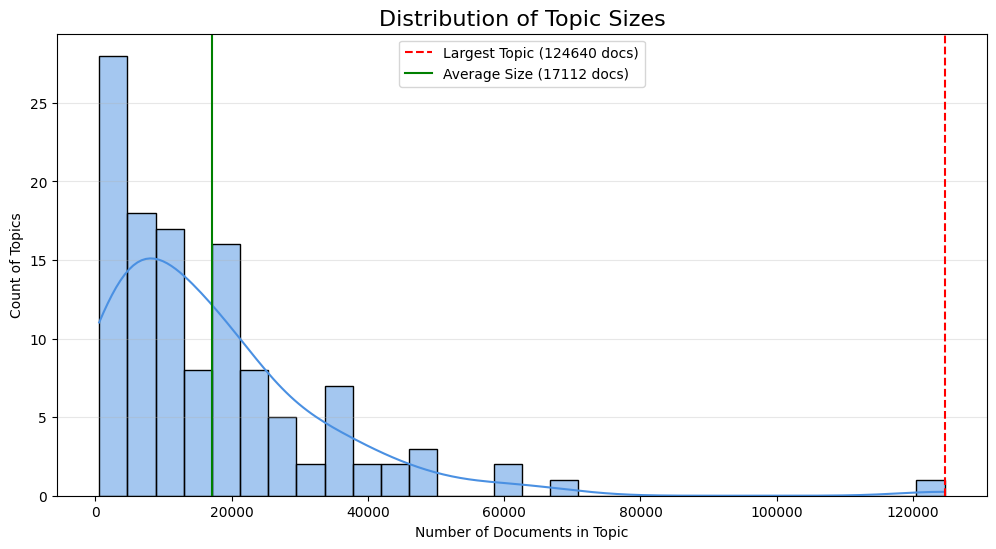

📊 סטטיסטיקה:
   - סה"כ נושאים: 120
   - הנושא הכי גדול: 124640 מסמכים
   - הנושא הכי קטן: 565 מסמכים


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_topic_size_distribution(model):
    topic_sizes, topic_nums = model.get_topic_sizes()
    
    plt.figure(figsize=(12, 6))
    sns.histplot(topic_sizes, bins=30, kde=True, color='#4a90e2')
    plt.title("Distribution of Topic Sizes", fontsize=16)
    plt.xlabel("Number of Documents in Topic")
    plt.ylabel("Count of Topics")
    plt.grid(axis='y', alpha=0.3)
    
    # סימון הנושא הגדול ביותר והקטן ביותר
    max_size = topic_sizes[0]
    min_size = topic_sizes[-1]
    plt.axvline(max_size, color='red', linestyle='--', label=f'Largest Topic ({max_size} docs)')
    plt.axvline(np.mean(topic_sizes), color='green', linestyle='-', label=f'Average Size ({int(np.mean(topic_sizes))} docs)')
    
    plt.legend()
    plt.show()
    
    print(f"📊 סטטיסטיקה:")
    print(f"   - סה\"כ נושאים: {len(topic_nums)}")
    print(f"   - הנושא הכי גדול: {max_size} מסמכים")
    print(f"   - הנושא הכי קטן: {min_size} מסמכים")

plot_topic_size_distribution(model)

In [26]:
import numpy as np

print("len(input_docs):", len(df_wiki['clean_text_v2'].tolist()))

# במידה והמודל שומר ids / מידע על מסמכים (לפעמים לא אם keep_documents=False)
for attr in ["documents", "document_ids", "document_vectors", "doc_vectors"]:
    if hasattr(model, attr):
        v = getattr(model, attr)
        try:
            print(attr, "len =", len(v))
        except Exception:
            print(attr, "exists אבל אי אפשר למדוד len")


len(input_docs): 4999
documents len = 4999
document_ids len = 4999
document_vectors len = 52922


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [27]:
topic_sizes, topic_nums = model.get_topic_sizes()
print("sum(topic_sizes):", int(np.sum(topic_sizes)))
print("max(topic_size):", int(np.max(topic_sizes)))
print("n_topics:", len(topic_nums))


sum(topic_sizes): 2053501
max(topic_size): 124640
n_topics: 120


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [28]:
import numpy as np

# מטריצה: [n_docs x n_topics] של רלוונטיות
rel = model.get_document_topic_relevance()
print(rel.shape)  # צריך להיות (4999, 109)

# שיוך topic לכל מסמך: topic עם הציון הכי גבוה
doc_topic = np.argmax(rel, axis=1)

# ספירה
counts = np.bincount(doc_topic, minlength=rel.shape[1])
print("sum:", counts.sum(), "max:", counts.max(), "min:", counts.min())


(4999, 120)
sum: 4999 max: 264 min: 1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


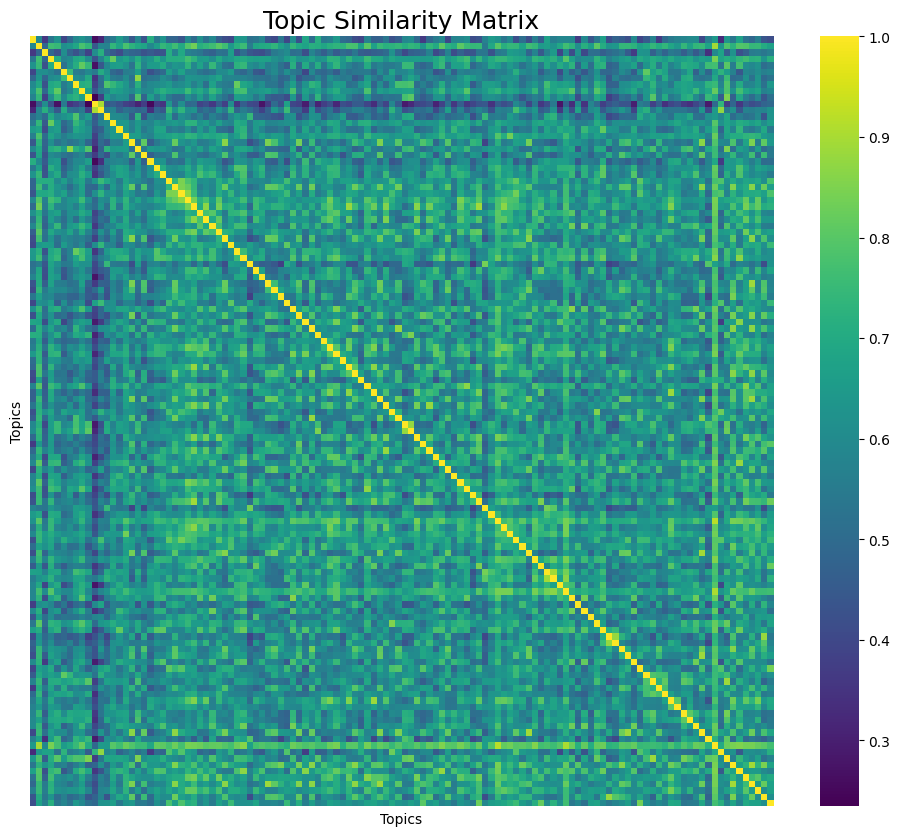

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

def plot_topic_similarity_heatmap(model):
    # חישוב דמיון בין כל הנושאים לבין עצמם
    # model.topic_vectors הוא מערך בגודל (109, 768)
    similarity_matrix = cosine_similarity(model.topic_vectors)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(similarity_matrix, cmap='viridis', xticklabels=False, yticklabels=False)
    plt.title("Topic Similarity Matrix", fontsize=18)
    plt.xlabel("Topics")
    plt.ylabel("Topics")
    plt.show()

plot_topic_similarity_heatmap(model)

In [30]:
from scipy.cluster.hierarchy import linkage, fcluster
import pandas as pd

def extract_super_topics(model, num_clusters=5):
    """
    מקבלץ את 109 הנושאים ל-5 קבוצות-על (Super-Topics) ומסביר מה הן.
    """
    print(f"🌟 מפענח את {num_clusters} הקבוצות העיקריות בדאטה...")
    
    # 1. יצירת ההיררכיה
    Z = linkage(model.topic_vectors, method='ward', metric='euclidean')
    
    # 2. חיתוך העץ ל-K קלאסטרים שטוחים
    cluster_labels = fcluster(Z, t=num_clusters, criterion='maxclust')
    
    topic_words, _, topic_nums = model.get_topics(model.get_num_topics())
    
    # 3. ניתוח כל קלאסטר
    df_clusters = pd.DataFrame({'Topic': topic_nums, 'Cluster': cluster_labels})
    
    for i in range(1, num_clusters + 1):
        # מציאת כל הנושאים ששייכים לקלאסטר הזה
        topics_in_cluster = df_clusters[df_clusters['Cluster'] == i]['Topic'].tolist()
        
        print(f"\n📂 Super-Topic #{i} (מכיל {len(topics_in_cluster)} תתי-נושאים):")
        
        # איסוף מילים מייצגות מכל הנושאים בקלאסטר הזה
        all_words = []
        for t_num in topics_in_cluster[:5]: # לוקחים דגימה של 5 נושאים
            # מציאת האינדקס של הנושא
            t_idx = np.where(topic_nums == t_num)[0][0]
            # לוקחים את המילה הראשונה והשנייה מכל נושא
            all_words.extend(topic_words[t_idx][:2])
            
        # הדפסת המילים שמאפיינות את הקבוצה הזו
        print(f"   מילות מפתח: {', '.join(list(set(all_words)))}") 
        print(f"   לדוגמה: נושאים {topics_in_cluster[:5]}...")

# הרצה
extract_super_topics(model, num_clusters=5)

🌟 מפענח את 5 הקבוצות העיקריות בדאטה...

📂 Super-Topic #1 (מכיל 33 תתי-נושאים):
   מילות מפתח: האירים, מו, ניצחונו, בעונתו, ויקרא, בסיוון, במבה, רו, נבחרתו, השקת
   לדוגמה: נושאים [1, 3, 13, 14, 15]...

📂 Super-Topic #2 (מכיל 23 תתי-נושאים):
   מילות מפתח: קיימברידג, עיטור, הדרגה, פרופ, עיצור, מדליית, יאנג, הנציב, הרב, נהוג
   לדוגמה: נושאים [0, 4, 6, 7, 8]...

📂 Super-Topic #3 (מכיל 19 תתי-נושאים):
   מילות מפתח: מפעלי, חטיבות, הדגל, תעופה, התעופה, חטיבת, הספריה, הסמל, מיוצר, הספרייה
   לדוגמה: נושאים [16, 18, 23, 31, 38]...

📂 Super-Topic #4 (מכיל 19 תתי-נושאים):
   מילות מפתח: מאורע, האירו, גבריאל, המטבע, כינוי, שפירושה, תומסון, לודוויג, אנטיגונוס, בתאריך
   לדוגמה: נושאים [2, 5, 10, 11, 22]...

📂 Super-Topic #5 (מכיל 26 תתי-נושאים):
   מילות מפתח: מבחני, הפקולטה, טמפרטורות, בתחרויות, בתרבויות, מסמנים, ההגייה, באוניברסיטת, הטמפרטורות, לימודי
   לדוגמה: נושאים [26, 28, 30, 36, 40]...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [31]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict

def build_meta_topics(model, n_meta=30, top_words=10):
    # topic vectors (אצל Top2Vec זה בדרך כלל topic_vectors)
    X = np.array(model.topic_vectors)

    clusterer = AgglomerativeClustering(
        n_clusters=n_meta,
        metric="cosine",
        linkage="average"
    )
    labels = clusterer.fit_predict(X)

    # words לכל topic
    topic_words, _, topic_nums = model.get_topics(model.get_num_topics())

    meta = defaultdict(list)
    for meta_id, words, tnum in zip(labels, topic_words, topic_nums):
        meta[meta_id].append((int(tnum), list(words[:top_words])))

    return labels, meta

labels, meta_topics = build_meta_topics(model, n_meta=30, top_words=10)

# הדפסה קריאה
for meta_id in sorted(meta_topics.keys()):
    print(f"\n🧠 Meta-topic {meta_id}  (contains {len(meta_topics[meta_id])} sub-topics)")
    for tnum, words in meta_topics[meta_id][:3]:
        print(f"  - topic {tnum}: {', '.join(words)}")



🧠 Meta-topic 0  (contains 23 sub-topics)
  - topic 14: ויקרא, בסיוון, בחשוון, בשבת, בשנה, פרשה, פרשת, שבועות, הפרשה, פסוק
  - topic 20: האלוהות, הבורא, מהות, הקדושה, האור, הבריאה, האלוהי, אינסופי, ההתפשטות, אינסוף
  - topic 21: ערעור, התביעה, בהליך, תביעה, עתירה, הוגשה, נדחתה, משפטו, הוגש, נפסק

🧠 Meta-topic 1  (contains 6 sub-topics)
  - topic 1: נבחרתו, בעונתו, באליפות, האליפות, ליגת, שיחק, במוקדמות, המצטיין, לטורניר, שחקני
  - topic 4: עיטור, מדליית, הפרס, צלב, אביר, הצלב, תוארו, עיטורים, לודוויג, בוכנוואלד
  - topic 8: הדרגה, הנציב, הגנרל, דרגות, גנרל, הרמטכ, סגן, דרגה, דיפלומט, הדרגות

🧠 Meta-topic 2  (contains 5 sub-topics)
  - topic 9: חואן, אבוחצירא, דייגו, גול, ויימאר, פרנסואה, טורינו, קרלוס, אוסטרי, גולה
  - topic 46: אירופית, אתניות, הולנדית, אירופיות, ובמדינות, בתרבויות, גרמנית, הגרמנית, סובייטית, מגרמנית
  - topic 60: קיימברידג, פנסילבניה, סיאטל, אילינוי, מיאמי, קרוליינה, קולורדו, אורלנדו, אוקלהומה, ויילס

🧠 Meta-topic 3  (contains 3 sub-topics)
  - topic 40: ההגייה, מסמנ

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [32]:
!pip install wordcloud

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=2169) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


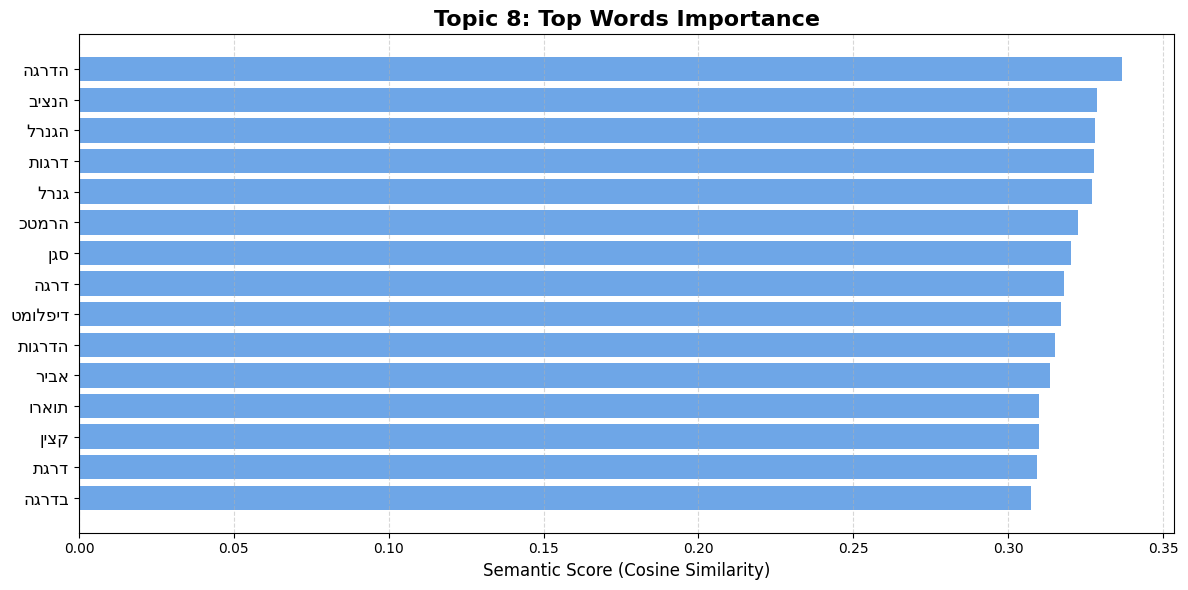

In [33]:
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
import numpy as np

def plot_topic_barchart(model, topic_num):
    # 1. שליפת הנתונים
    topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())
    
    try:
        topic_idx = np.where(topic_nums == topic_num)[0][0]
    except IndexError:
        print(f"❌ נושא {topic_num} לא נמצא.")
        return

    # לוקחים את 15 המילים החזקות ביותר
    top_n = 15
    words = topic_words[topic_idx][:top_n]
    scores = word_scores[topic_idx][:top_n]
    
    # 2. סידור עברית (היפוך כיוון בלבד)
    # בגרפים רגילים אין צורך ב-Reshape, רק ב-BiDi
    words_bidi = [get_display(w) for w in words]

    # 3. ציור הגרף
    plt.figure(figsize=(12, 6))
    
    # יצירת גרף עמודות אופקי
    plt.barh(range(top_n), scores, color='#4a90e2', alpha=0.8)
    
    # הוספת המילים בציר ה-Y
    plt.yticks(range(top_n), words_bidi, fontsize=12)
    
    # היפוך ציר Y כך שהמילה הכי חזקה תהיה למעלה
    plt.gca().invert_yaxis()
    
    plt.title(f"Topic {topic_num}: Top Words Importance", fontsize=16, fontweight='bold')
    plt.xlabel("Semantic Score (Cosine Similarity)", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# --- הרצה ---
# מציג את נושא הדרגות (8) בצורה נקייה ומדעית
plot_topic_barchart(model, topic_num=8)

In [34]:
import re, os, requests
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

%matplotlib inline

def download_noto_hebrew():
    css_url = "https://fonts.googleapis.com/css2?family=Noto+Sans+Hebrew:wght@400;700&display=swap"
    css = requests.get(css_url, timeout=20).text

    # מחפש URL של קובץ font בתוך ה-CSS
    m = re.search(r"src:\s*url\((https:[^)]+)\)\s*format\('(?:opentype|truetype)'\)", css)
    if not m:
        # fallback: לפעמים זה woff2 – נבחר בכל זאת ונשמור כ-woff2 (WordCloud לא אוהב), אז ננסה עוד דפוס:
        m = re.search(r"src:\s*url\((https:[^)]+\.woff2)\)", css)
        if not m:
            raise RuntimeError("לא מצאתי קישור לקובץ פונט ב-CSS")

    font_url = m.group(1)

    # ננסה להוריד. אם זה woff2 — עדיף להשתמש בפתרון השני למטה (zip מ-google fonts).
    ext = ".otf" if ".otf" in font_url else (".ttf" if ".ttf" in font_url else ".woff2")
    font_path = "NotoSansHebrew" + ext

    r = requests.get(font_url, timeout=30)
    r.raise_for_status()
    with open(font_path, "wb") as f:
        f.write(r.content)
    return font_path

font_path = download_noto_hebrew()
print("Downloaded:", font_path, "size:", os.path.getsize(font_path))


Downloaded: NotoSansHebrew.ttf size: 46496


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


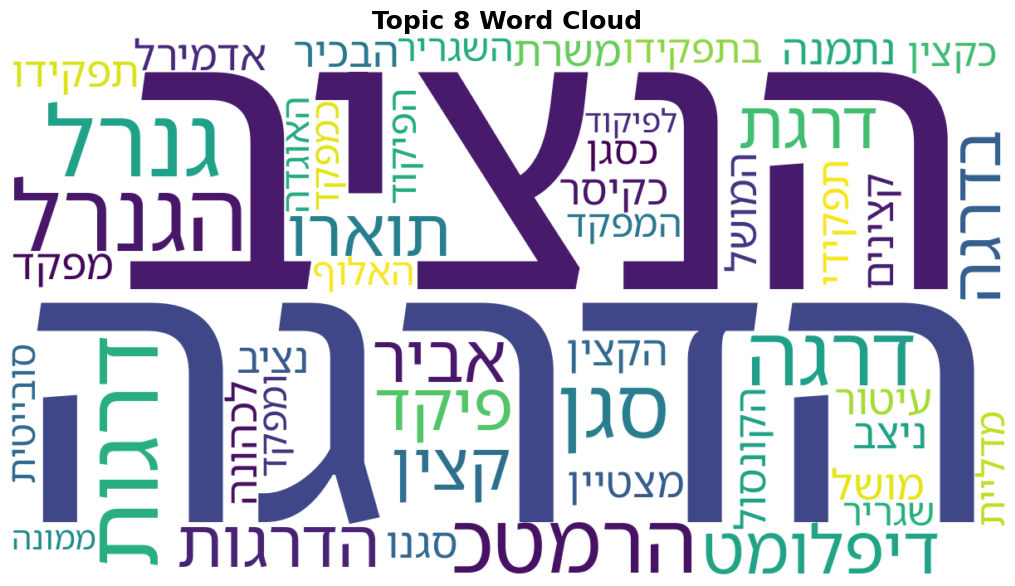

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_hebrew_wordcloud(model, topic_num, font_path, max_words=50):
    topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())
    topic_nums = list(topic_nums)
    idx = topic_nums.index(topic_num)

    freqs = {str(w).strip(): float(s)
             for w, s in zip(topic_words[idx], word_scores[idx])
             if str(w).strip()}

    wc = WordCloud(
        font_path=font_path,
        background_color="white",
        width=1200,
        height=650,
        max_words=max_words,
        collocations=False,
        random_state=7,
        regexp=r"[\u0590-\u05FF׳״']+"
    ).generate_from_frequencies(freqs)

    plt.figure(figsize=(14, 7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_num} Word Cloud", fontsize=18, fontweight="bold")
    plt.show()

plot_hebrew_wordcloud(model, 8, font_path="NotoSansHebrew.ttf")


In [36]:
from sentence_transformers import SentenceTransformer

# 1. טעינת המודל ידנית (אותו מודל שבו השתמשנו לאימון)
print("🔧 מתקן את פונקציית ה-Embed של המודל...")
encoder = SentenceTransformer('imvladikon/sentence-transformers-alephbert')

# 2. הצמדת פונקציית הקידוד למודל ה-Top2Vec
# זה פותר את השגיאה 'no attribute embed'
model.embed = encoder.encode

print("✅ המודל תוקן! עכשיו אפשר לבצע חיפוש סמנטי.")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


🔧 מתקן את פונקציית ה-Embed של המודל...
✅ המודל תוקן! עכשיו אפשר לבצע חיפוש סמנטי.


--- בדיקת חיפוש ---
🔍 מחפש נושאים עבור השאילתה: 'מלחמות ישראל'

🏆 מקום 1: נושא 111 (התאמה: 0.391)
   מילות מפתח: אנטיגונוס, אנטיוכוס, אנטיפטרוס, אדריאנוס, ממלכתו
   📄 מסמך מייצג: אירועים תאודוסיוס השני יורש אביו ארקדיוס כקיסר המזרח באימפריה הרומית קיץ קונסטנטינוס השלישי לוכד ספרד ומשמיד נאמני רומא המגינים עליה ספטמבר אלאריק מלך...

🏆 מקום 2: נושא 10 (התאמה: 0.391)
   מילות מפתח: מאורע, בתאריך, תאריך, לידתו, גאוגרפיים
   📄 מסמך מייצג: אירועים נולדו נפטרו לוח שנה שנת לפי הלוח היוליאני...

🏆 מקום 3: נושא 11 (התאמה: 0.390)
   מילות מפתח: לודוויג, אנטיגונוס, הרנסאנס, וילהלם, באך
   📄 מסמך מייצג: אירועים נולדו לודוויג ואן בטהובן נפטרו לוח שנה שנת לפי הלוח היוליאני...
🔍 מחפש נושאים עבור השאילתה: 'כלכלה וכסף'

🏆 מקום 1: נושא 2 (התאמה: 0.437)
   מילות מפתח: כינוי, שפירושה, בשמות, כתובות, הונגרית
   📄 מסמך מייצג: באך משפחה שמקורו בגרמנית ופירושו נחל שמות משפחה אשכנזיים שמות משפחה גרמניים...

🏆 מקום 2: נושא 22 (התאמה: 0.388)
   מילות מפתח: המטבע, האירו, בתרבויות, סובייטי, המיראז
   📄 מסמך מייצג: 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipykernel_2169/1246618772.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=topic_labels, palette="viridis")


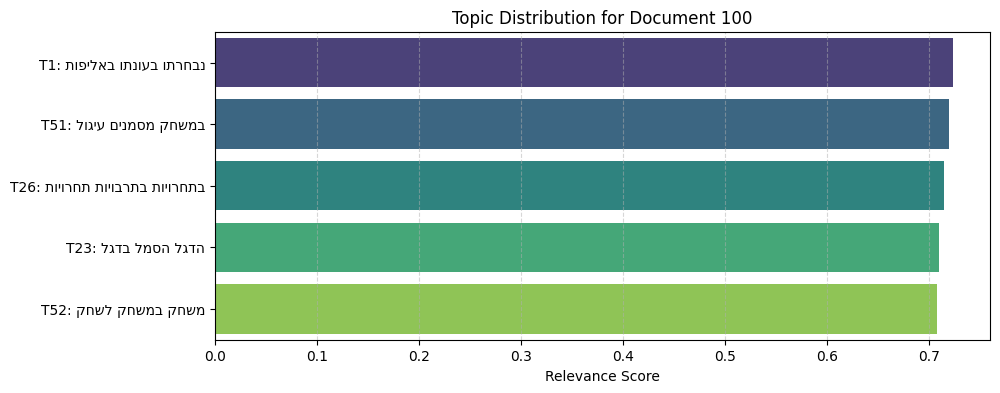

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bidi.algorithm import get_display

# --- פונקציה 1: חיפוש סמנטי (Search) ---
def search_topics_by_query_fixed(model, query, documents, num_topics=3):
    """
    חיפוש סמנטי מתוקן למודל C-Top2Vec.
    עוקף את חסימת המסמכים ע"י שימוש במטריצת רלוונטיות.
    """
    print(f"🔍 מחפש נושאים עבור השאילתה: '{query}'")
    
    # 1. מציאת הנושאים הקרובים לשאילתה
    topic_words, word_scores, topic_scores, found_topic_nums = model.query_topics(query, num_topics=num_topics)
    
    # 2. שליפת כל הנושאים מהמודל כדי למפות אינדקסים (פותר את ה-AttributeError)
    all_topic_words, _, all_topic_nums = model.get_topics(model.get_num_topics())
    
    # 3. חישוב מטריצת רלוונטיות (פעם אחת עבור החיפוש)
    try:
        relevance_matrix = model.get_document_topic_relevance()
    except Exception as e:
        print(f"⚠️ שגיאה בחישוב רלוונטיות: {e}")
        return

    for i in range(num_topics):
        topic_num = found_topic_nums[i]
        score = topic_scores[i]
        words = ", ".join(topic_words[i][:5])
        
        print(f"\n🏆 מקום {i+1}: נושא {topic_num} (התאמה: {score:.3f})")
        print(f"   מילות מפתח: {words}")
        
        # --- שליפת מסמך מייצג (התיקון) ---
        try:
            # א. מציאת האינדקס הפנימי של הנושא (העמודה במטריצה)
            # אנחנו מחפשים איפה המספר topic_num נמצא בתוך המערך המלא all_topic_nums
            topic_col_idx = np.where(all_topic_nums == topic_num)[0][0]
            
            # ב. מציאת המסמך הכי רלוונטי לנושא הזה (השורה עם הערך המקסימלי בעמודה)
            best_doc_idx = np.argmax(relevance_matrix[:, topic_col_idx])
            
            # ג. שליפת הטקסט (מתוך הרשימה שהעברנו לפונקציה)
            doc_preview = documents[best_doc_idx][:150] 
            print(f"   📄 מסמך מייצג: {doc_preview}...")
            
        except Exception as e:
            print(f"   ⚠️ לא ניתן לשלוף מסמך: {e}")


# --- פונקציה 2: ניתוח מסמך (Document Breakdown) ---
def analyze_document_topics_fixed(model, doc_index, documents):
    """
    מנתח את התפלגות הנושאים במסמך ספציפי.
    תוקן כדי להימנע מגישה ישירה ל-model.topic_nums.
    """
    # שליפת הטקסט
    text_preview = documents[doc_index][:100]
    print(f"📄 מנתח את המסמך (אינדקס {doc_index}):\n'{text_preview}...'")
    
    # חישוב ציוני הרלוונטיות
    relevance_matrix = model.get_document_topic_relevance()
    doc_scores = relevance_matrix[doc_index]
    
    # 5 הנושאים החזקים ביותר למסמך זה
    top_indices = np.argsort(doc_scores)[-5:][::-1]
    top_scores = doc_scores[top_indices]
    
    # שליפת המידע המלא מהמודל בצורה בטוחה
    all_topic_words, _, all_topic_nums = model.get_topics(model.get_num_topics())
    
    # הכנת תוויות לגרף
    topic_labels = []
    for idx in top_indices:
        # idx הוא האינדקס בעמודות המטריצה, שתואם לאינדקס ב-all_topic_nums
        real_topic_num = all_topic_nums[idx]
        words = all_topic_words[idx][:3]
        
        label = f"T{real_topic_num}: {' '.join(words)}"
        topic_labels.append(get_display(label)) # היפוך עברית לגרף
        
    # ציור הגרף
    plt.figure(figsize=(10, 4))
    sns.barplot(x=top_scores, y=topic_labels, palette="viridis")
    plt.title(f"Topic Distribution for Document {doc_index}")
    plt.xlabel("Relevance Score")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()

# --- הרצה ---
# יש להעביר את רשימת הטקסטים המקורית (clean_text_v2) לפונקציות
docs_list = df_wiki['clean_text_v2'].tolist()

print("--- בדיקת חיפוש ---")
search_topics_by_query_fixed(model, "מלחמות ישראל", docs_list)
search_topics_by_query_fixed(model, "כלכלה וכסף", docs_list)

print("\n--- בדיקת ניתוח מסמך ---")
# בחרנו מסמך שעוסק בכדורגל (לפי הבדיקה שלך קודם)
analyze_document_topics_fixed(model, doc_index=100, documents=docs_list)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


🗺️ מייצר מפה דו-ממדית של הנושאים...


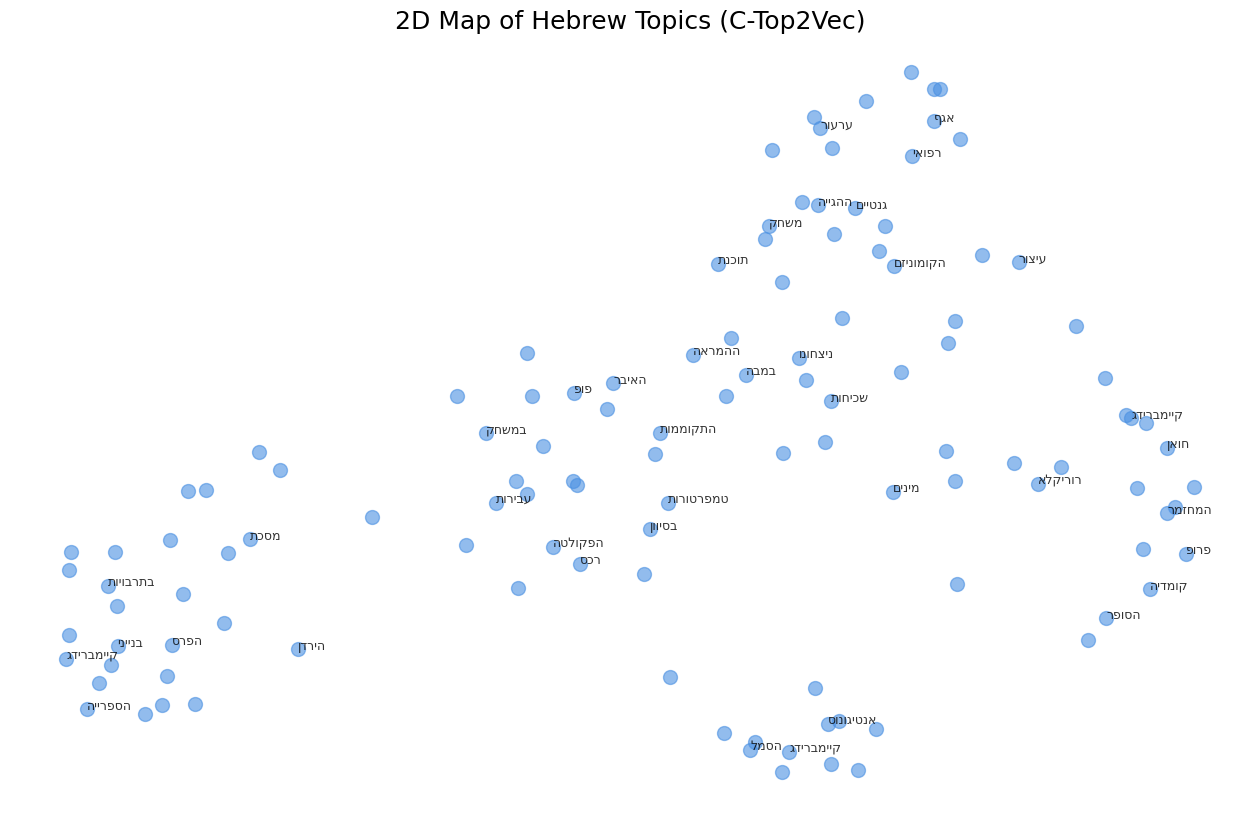

🌳 מייצר עץ היררכי של הנושאים...


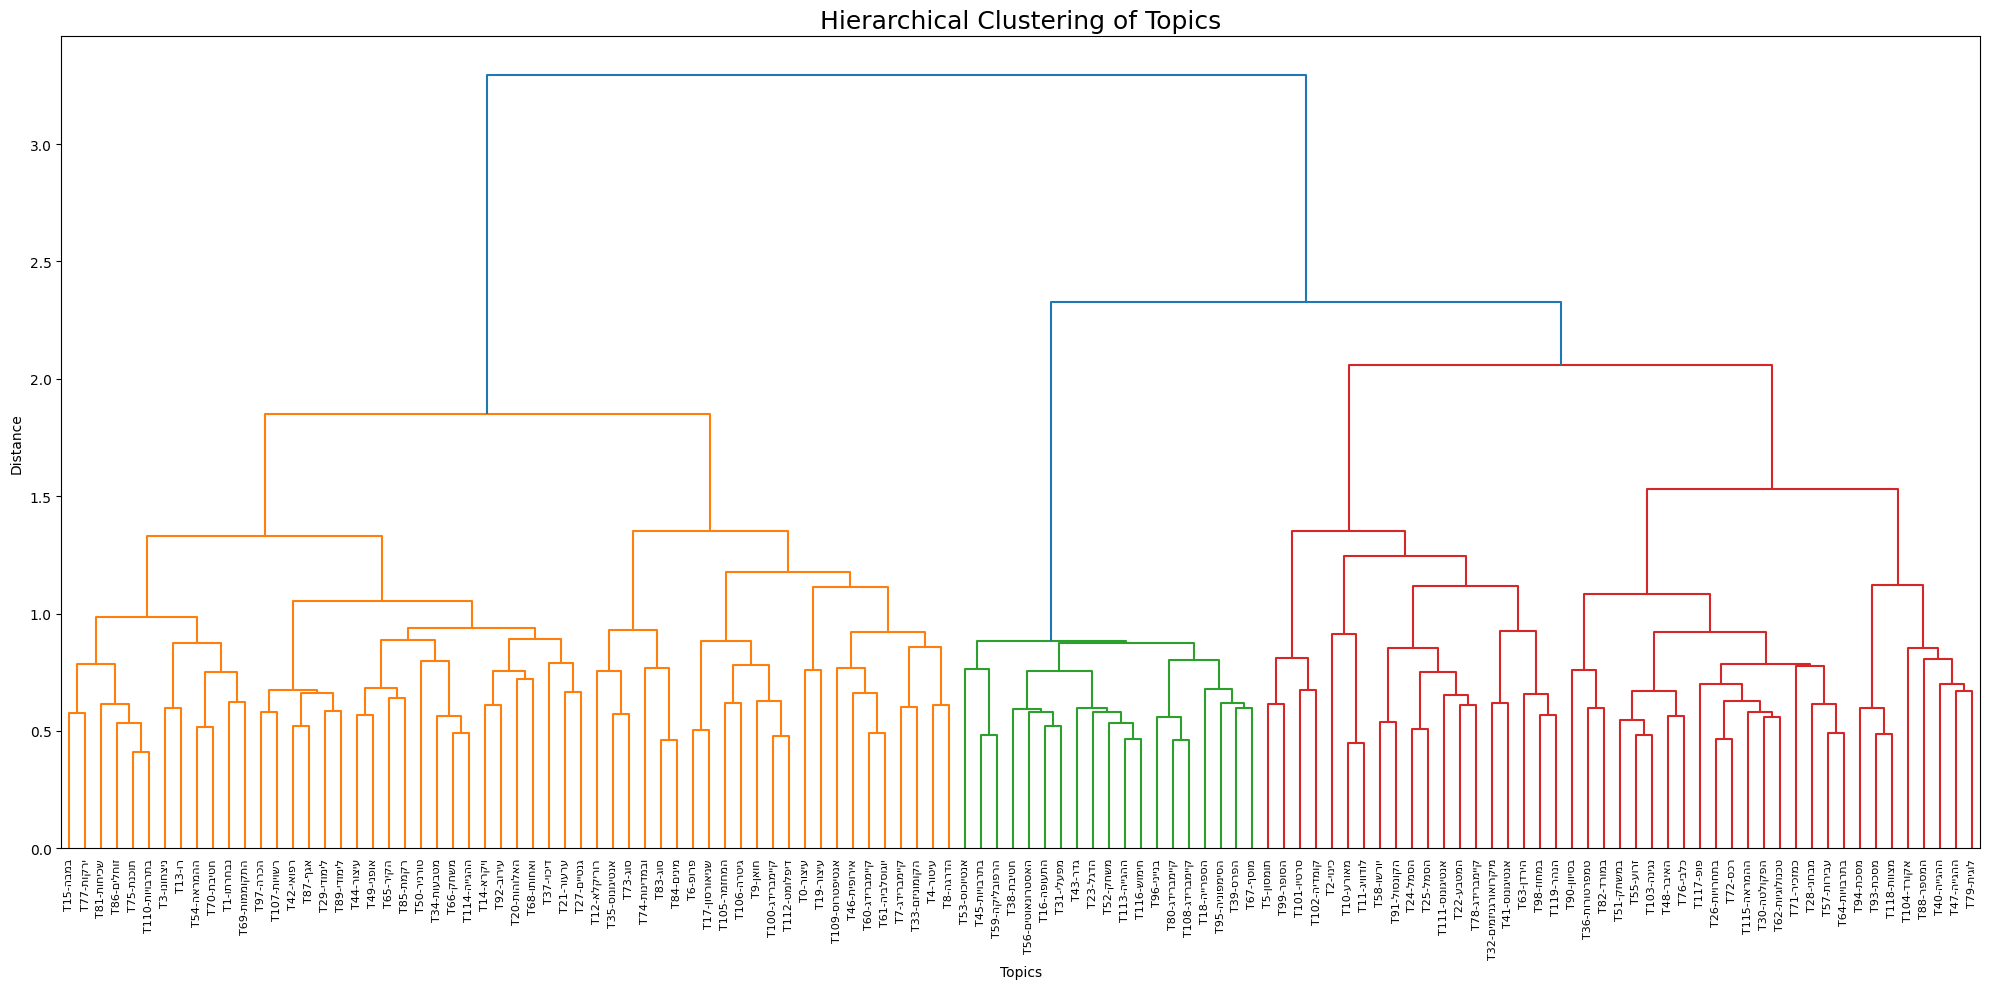

In [38]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from bidi.algorithm import get_display
import umap
import numpy as np

# --- 1. מפת נושאים (2D Topic Map) ---
def plot_topic_map_2d(model):
    print("🗺️ מייצר מפה דו-ממדית של הנושאים...")
    
    # שימוש ב-UMAP כדי לכווץ את וקטורי הנושאים (768 מימדים) ל-2 מימדים
    # אנו משתמשים ב-topic_vectors של המודל
    umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
    embeddings_2d = umap_model.fit_transform(model.topic_vectors)
    
    # שליפת המילים המייצגות לכל נושא
    topic_words, _, topic_nums = model.get_topics(model.get_num_topics())
    
    plt.figure(figsize=(16, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='#4a90e2', alpha=0.6, s=100)
    
    # הוספת טקסט למפה (רק לחלק מהנושאים כדי לא להעמיס)
    for i in range(len(topic_nums)):
        # מציג טקסט רק עבור כל נושא שלישי, או נושאים בולטים
        if i % 3 == 0: 
            label = topic_words[i][0] # המילה הראשונה בנושא
            label_bidi = get_display(label)
            plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], label_bidi, fontsize=9, alpha=0.8)
            
    plt.title("2D Map of Hebrew Topics (C-Top2Vec)", fontsize=18)
    plt.axis('off')
    plt.show()

# --- 2. דנדרוגרמה (Topic Hierarchy) ---
def plot_dendrogram_safe(model):
    print("🌳 מייצר עץ היררכי של הנושאים...")
    
    # חישוב היררכיה
    Z = linkage(model.topic_vectors, method='ward', metric='euclidean')
    
    topic_words, _, topic_nums = model.get_topics(model.get_num_topics())
    
    # הכנת תוויות (מספר נושא + מילה מובילה)
    labels = []
    for i in range(len(topic_nums)):
        w = topic_words[i][0]
        lbl = f"T{topic_nums[i]}-{w}"
        labels.append(get_display(lbl))
        
    plt.figure(figsize=(20, 10))
    dendrogram(
        Z,
        labels=labels,
        leaf_rotation=90.,
        leaf_font_size=8.,
    )
    plt.title("Hierarchical Clustering of Topics", fontsize=18)
    plt.xlabel("Topics")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()

# --- הרצה ---
# וודא שמותקנת ספריית umap-learn (בדרך כלל באה עם top2vec)
# !pip install umap-learn

plot_topic_map_2d(model)
plot_dendrogram_safe(model)

In [39]:
import numpy as np

def doc_topic_counts_contextual(model):
    rel = model.get_document_topic_relevance()  # (n_docs, n_topics)
    doc_topic = np.argmax(rel, axis=1)
    counts = np.bincount(doc_topic, minlength=rel.shape[1])
    return counts

counts_before = doc_topic_counts_contextual(model)
print("Before topics:", model.get_num_topics())
print("Before max:", counts_before.max(), "min:", counts_before.min(), "topics with 1 doc:", int((counts_before==1).sum()))


Before topics: 120
Before max: 264 min: 1 topics with 1 doc: 2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [47]:
# =========================
# EXPORT — C-Top2Vec artifacts (NOT reduced) — WORKS WITHOUT blocked APIs
# =========================
from pathlib import Path
import numpy as np
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

# ---- sanity ----
assert "model" in globals(), "Missing variable: model"
assert ("df_wiki" in globals()) or ("df_ugc" in globals()), "Missing df_wiki/df_ugc"

# ---- output folder (לפי מודל) ----
RESULTS_ROOT = RESULTS_DIR
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)

# ---- dataset pick (עדכן אם צריך) ----
DATASET_NAME = "Wiki_clean_text_v2"
docs_for_coh = df_wiki["clean_text_v2"].fillna("").tolist()

TOP_WORDS = 12
TOP_DOCS_PER_TOPIC = 3

# ---- topics words + ids ----
try:
    topic_words, word_scores, topic_nums = get_topics_safe(model, reduced=False)
except NameError:
    topic_words, word_scores, topic_nums = model.get_topics(reduced=False)

# ---- topic sizes ----
try:
    topic_sizes, topic_nums2 = get_topic_sizes_safe(model, reduced=False)
except Exception:
    try:
        topic_sizes, topic_nums2 = model.get_topic_sizes(reduced=False)
    except TypeError:
        topic_sizes, topic_nums2 = model.get_topic_sizes()

# ---- coherence + diversity ----
tokenized = [d.split() for d in docs_for_coh]
dictionary = Dictionary(tokenized)
cm = CoherenceModel(
    topics=[list(t[:TOP_WORDS]) for t in topic_words],
    texts=tokenized,
    dictionary=dictionary,
    coherence="c_v"
)
coherence_cv = cm.get_coherence()

flat = [w for t in topic_words for w in t[:TOP_WORDS]]
diversity = len(set(flat)) / len(flat) if len(flat) else np.nan

# ---- metrics (1 row) ----
metrics_df = pd.DataFrame([{
    "stage": 4,
    "platform": "kaggle_or_colab",
    "model": "C-Top2Vec",
    "dataset": DATASET_NAME,
    "num_topics": int(len(topic_nums)),
    "coherence_cv": float(coherence_cv),
    "topic_diversity": float(diversity),
    "notes": ""
}])

# ---- topics ----
topics_rows = []
for i, tnum in enumerate(topic_nums):
    topics_rows.append({
        "model": "C-Top2Vec",
        "dataset": DATASET_NAME,
        "topic_id": int(tnum),
        "top_terms": ", ".join(topic_words[i][:TOP_WORDS]),
        "topic_size": int(topic_sizes[i]) if i < len(topic_sizes) else np.nan
    })
topics_df = pd.DataFrame(topics_rows)

# =========================
# EXAMPLES — use doc_topic_distribution (allowed) instead of blocked APIs
# =========================

# 1) make sure doc-topic distributions exist (compute if needed)
doc_topic_dist = getattr(model, "doc_topic_distribution", None)

if doc_topic_dist is None or (isinstance(doc_topic_dist, (list, np.ndarray)) and len(doc_topic_dist) == 0):
    # try to compute distributions (this method exists in your model dir() output)
    try:
        model.calculate_documents_topic_distributions(documents=docs_for_coh)
    except TypeError:
        model.calculate_documents_topic_distributions(docs_for_coh)

    doc_topic_dist = getattr(model, "doc_topic_distribution", None)

if doc_topic_dist is None:
    raise RuntimeError(
        "doc_topic_distribution is not available even after calculate_documents_topic_distributions(). "
        "Try running model.compute_topics() earlier, then rerun this export cell."
    )

doc_topic_dist = np.array(doc_topic_dist)  # shape: (n_docs, K)

# 2) build examples: for each topic column, pick top docs by probability
# IMPORTANT: we assume columns align with the order returned by get_topics()
# (topic_words[i] corresponds to column i). We export topic_id=topic_nums[i].
examples_rows = []
K = doc_topic_dist.shape[1]
K_use = min(K, len(topic_nums), len(topic_words))

for i in range(K_use):
    tid = int(topic_nums[i])
    scores_i = doc_topic_dist[:, i]
    top_idx = np.argsort(-scores_i)[:TOP_DOCS_PER_TOPIC]
    for did in top_idx:
        examples_rows.append({
            "model": "C-Top2Vec",
            "dataset": DATASET_NAME,
            "topic_id": tid,
            "doc_id": int(did),
            "doc_text_short": str(docs_for_coh[did])[:400].replace("\n", " ")
        })

examples_df = pd.DataFrame(examples_rows)

# ---- save ----
metrics_df.to_csv(RESULTS_ROOT / "metrics_c_top2vec.csv", index=False)
topics_df.to_csv(RESULTS_ROOT / "topics_c_top2vec.csv", index=False)
examples_df.to_csv(RESULTS_ROOT / "examples_c_top2vec.csv", index=False)

display(metrics_df)
print("topics rows:", len(topics_df), "| examples rows:", len(examples_df))
print("✅ Saved:", RESULTS_ROOT.resolve())


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2169) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


,stage,platform,model,dataset,num_topics,coherence_cv,topic_diversity,notes
0,4,kaggle_or_colab,C-Top2Vec,Wiki_clean_text_v2,120,0.456658,0.695833,


topics rows: 120 | examples rows: 360
✅ Saved: /kaggle/working/results_artifacts/c_top2vec


In [44]:
# DEBUG: list potential APIs for contextual top2vec
candidates = [m for m in dir(model) if any(k in m.lower() for k in ["span", "segment", "context", "topic", "document", "assign", "predict", "transform", "distribution"])]
candidates[:200], len(candidates)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


(['_assign_documents_to_topic',
  '_calculate_documents_topic',
  '_calculate_topic_sizes',
  '_check_document_index_status',
  '_create_document_topic_structure',
  '_create_topic_vectors',
  '_deduplicate_topics',
  '_embed_documents',
  '_find_topic_words_and_scores',
  '_get_document_ids',
  '_get_document_indexes',
  '_reorder_topics',
  '_unassign_documents_from_topic',
  '_validate_document_ids_add_doc',
  '_validate_documents',
  '_validate_hierarchical_reduction_num_topics',
  '_validate_num_topics',
  '_validate_topic_num',
  '_validate_topic_search',
  'add_documents',
  'calculate_documents_topic_distributions',
  'compute_topics',
  'contextual_top2vec',
  'delete_documents',
  'doc_topic_distribution',
  'doc_topic_scores',
  'document_ids',
  'document_ids_provided',
  'document_index',
  'document_labels',
  'document_token_embeddings',
  'document_tokens',
  'document_vectors',
  'documents',
  'documents_indexed',
  'generate_topic_wordcloud',
  'get_document_token_to

In [45]:
# DEBUG: print only the most relevant names (short list)
for m in candidates:
    if any(k in m.lower() for k in ["span", "segment", "assign", "predict", "distribution", "transform"]):
        print(m)


_assign_documents_to_topic
_unassign_documents_from_topic
calculate_documents_topic_distributions
doc_topic_distribution
get_document_token_topic_assignment
get_document_topic_distribution


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [41]:
import inspect

def get_num_topics_safe(model, reduced=False):
    sig = inspect.signature(model.get_num_topics)
    if "reduced" in sig.parameters:
        return model.get_num_topics(reduced=reduced)
    return model.get_num_topics()

def get_topics_safe(model, n=None, reduced=False):
    if n is None:
        n = get_num_topics_safe(model, reduced=reduced)
    sig = inspect.signature(model.get_topics)
    if "reduced" in sig.parameters:
        return model.get_topics(n, reduced=reduced)
    return model.get_topics(n)

def get_topic_sizes_safe(model, reduced=False):
    sig = inspect.signature(model.get_topic_sizes)
    if "reduced" in sig.parameters:
        return model.get_topic_sizes(reduced=reduced)
    return model.get_topic_sizes()


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [42]:
print("Original topics:", get_num_topics_safe(model, reduced=False))
print("Reduced topics:",  get_num_topics_safe(model, reduced=True))

topic_words, word_scores, topic_nums = get_topics_safe(model, reduced=True)

for i in range(min(10, len(topic_nums))):
    print(f"Topic {topic_nums[i]}: {', '.join(topic_words[i][:10])}")


Original topics: 120


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


ValueError: Hierarchical topic reduction has not been performed.

**הערה:** אם לא בוצע hierarchical reduction, הקריאה ל-`get_num_topics(reduced=True)` תזרוק `ValueError`. זה צפוי ולא משפיע על שאר התוצאות במחברת.


In [ ]:
import numpy as np
import inspect

def doc_topic_counts_contextual(model, reduced=False):
    rel_fn = model.get_document_topic_relevance
    sig = inspect.signature(rel_fn)
    if "reduced" in sig.parameters:
        rel = rel_fn(reduced=reduced)
    else:
        rel = rel_fn()
    doc_topic = np.argmax(rel, axis=1)
    counts = np.bincount(doc_topic, minlength=rel.shape[1])
    return counts, rel.shape

counts30, shape30 = doc_topic_counts_contextual(model, reduced=True)
print("Relevance shape:", shape30)
print("sum:", counts30.sum(), "max:", counts30.max(), "min:", counts30.min(), "1-doc topics:", int((counts30==1).sum()))
